## PUBG Modelling

플레이어들이 전장에서 벌이는 모든 행위를 분류하여 승리를 예측하기 위한 프로젝트

## Column 별 정보
- ASSISTS : 자신에 의해 사살되지는 못했지만 자신의 데미지 지분율이 가장 높은 적의 수
- BOOSTS : 도핑 아이템 사용 횟수(에너지 드링크, 진통제, 아드레날린 주사기)
- DAMAGEDEALT : 적에게 가한 전체 데미지
- DBNOS : 기절시킨 적의 수
- GROUPID : 경기 내 그룹 식별 ID
- HEADSHOTKILLS : 헤드샷으로 죽인 적의 수
- HEALS : 회복 아이템 사용 횟수(붕대, 구급상자, 의료용 키트)
- ID : 해당 데이터 ID
- KILLPLACE : 경기 내 적을 죽인 적 수의 순위
- KILLPOINTS : 유저의 ELO레이팅(죽인 적 수 기반)
- KILLS : 경기 내 적을 죽인 수
- KILLSTREAKS : 짧은 시간 내에 연속으로 적을 죽인 수
- LONGESTKILL : 사살한 적까지의 거리의 최대값
- MATCHDURATION : 경기가 진행된 시간(단위:초)
- MATCHID : 경기 식별 ID
- MATCHTYPE : 경기 모드( ex: 솔로, 듀오, 스쿼드 )
- MAXPLACE : 경기 내 총 인원 수
- NUMGROUP : 경기 내 실제 참여 인원 수
- RANKPOINTS : 유저의 ELO 레이팅
- REVIVES : 유저가 팀원을 부활시킨 횟수
- RIDEDISTANCE : 이동수단을 통해 이동한 거리(단위:m)
- ROADKILLS : 이동수단으로 살해한 적의 수
- SWIMDISTANCE : 수영으로 이동한 거리(단위:m)
- TEAMKILLS : 같은 팀원을 살해한 수
- VEHICLEDESTROYS : 파괴한 이동수단의 수
- WALKDISTANCE : 도보로 이동한 거리(단위:m)
- WEAPONSACQUIRED : 획득한 무기의 수
- WINPOINTS : 유저의 ELO 레이팅(승리 횟수 기반)
- WINPLACEPERC : 현재 경기에서의 백분위 기반 유저의 순위(종속변수)

## 라이브러리 및 데이터 불러오기

In [2]:
# 데이터 분석
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 모델들, 성능 평가
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from lightgbm.sklearn import LGBMClassifier
from lightgbm.sklearn import LGBMRegressor

# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import KFold
from functools import partial

import scipy as sp
from scipy import stats
import sys
import warnings                      
warnings.filterwarnings("ignore")
import os
import gc
print(os.listdir("./data/pubg-finish-placement-prediction/"))

['sample_submission_V2.csv', 'test_V2.csv', 'train_V2.csv']


In [2]:
train = pd.read_csv("./data/pubg-finish-placement-prediction/train_V2.csv")
test = pd.read_csv("./data/pubg-finish-placement-prediction/test_V2.csv")
submission = pd.read_csv("./data/pubg-finish-placement-prediction/sample_submission_V2.csv")

In [3]:
print(train.shape, test.shape)

(4446966, 29) (1934174, 28)


In [4]:
print(submission.shape)

(1934174, 2)


In [5]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    #start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    #end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

In [6]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00000,0,0,0,60,...,0,0.000000,0,0.000000,0,0,244.75,1,1466,0.444336
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,...,0,0.004501,0,11.039062,0,0,1434.00,5,0,0.640137
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,...,0,0.000000,0,0.000000,0,0,161.75,2,0,0.775391
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,...,0,0.000000,0,0.000000,0,0,202.75,3,0,0.166748
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,...,0,0.000000,0,0.000000,0,0,49.75,2,0,0.187500


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int8   
 4   boosts           int8   
 5   damageDealt      float16
 6   DBNOs            int8   
 7   headshotKills    int8   
 8   heals            int8   
 9   killPlace        int8   
 10  killPoints       int16  
 11  kills            int8   
 12  killStreaks      int8   
 13  longestKill      float16
 14  matchDuration    int16  
 15  matchType        object 
 16  maxPlace         int8   
 17  numGroups        int8   
 18  rankPoints       int16  
 19  revives          int8   
 20  rideDistance     float16
 21  roadKills        int8   
 22  swimDistance     float16
 23  teamKills        int8   
 24  vehicleDestroys  int8   
 25  walkDistance     float16
 26  weaponsAcquired  int16  
 27  winPoints   

In [8]:
train.isna().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

In [9]:
train[train.winPlacePerc.isna()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [10]:
train = train.dropna(axis=0)

In [11]:
# train = train.drop(["Id", "groupId","matchId"], axis=1)
train = train.drop(["Id", "groupId"], axis=1)

- Id, groupId, matchId 들은 예측에 전혀 필요가 없는 컬럼이므로 드랍

In [12]:
train.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,4.446965e+06,4.446965e+06,4446965.00,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,...,4.446965e+06,4.446965e+06,4.446965e+06,4446965.0,4.446965e+06,4.446965e+06,4446965.000,4.446965e+06,4.446965e+06,4.446965e+06
mean,2.338150e-01,1.106908e+00,NaN,6.578757e-01,2.268196e-01,1.370148e+00,4.759936e+01,5.050062e+02,9.247835e-01,5.439553e-01,...,1.646590e-01,NaN,3.496092e-03,NaN,2.386841e-02,7.918209e-03,NaN,3.660488e+00,6.064603e+02,NaN
std,5.885731e-01,1.715794e+00,NaN,1.145743e+00,6.021553e-01,2.679982e+00,2.746293e+01,6.275049e+02,1.558445e+00,7.109721e-01,...,4.721671e-01,NaN,7.337297e-02,NaN,1.673935e-01,9.261158e-02,NaN,2.456543e+00,7.397005e+02,0.000000e+00
min,0.000000e+00,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,155.125,2.000000e+00,0.000000e+00,1.999512e-01
50%,0.000000e+00,0.000000e+00,84.25,0.000000e+00,0.000000e+00,0.000000e+00,4.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,685.500,3.000000e+00,0.000000e+00,4.582520e-01
75%,0.000000e+00,2.000000e+00,186.00,1.000000e+00,0.000000e+00,2.000000e+00,7.100000e+01,1.172000e+03,1.000000e+00,1.000000e+00,...,0.000000e+00,1.910400e-01,0.000000e+00,0.0,0.000000e+00,0.000000e+00,1976.000,5.000000e+00,1.495000e+03,7.407227e-01
max,2.200000e+01,3.300000e+01,6616.00,5.300000e+01,6.400000e+01,8.000000e+01,1.010000e+02,2.170000e+03,7.200000e+01,2.000000e+01,...,3.900000e+01,4.070400e+04,1.800000e+01,3824.0,1.200000e+01,5.000000e+00,25776.000,2.360000e+02,2.013000e+03,1.000000e+00


In [13]:
train.head()

,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,a10357fd1a4a91,0,0,0.00000,0,0,0,60,1241,0,...,0,0.000000,0,0.000000,0,0,244.75,1,1466,0.444336
1,aeb375fc57110c,0,0,91.50000,0,0,0,57,0,0,...,0,0.004501,0,11.039062,0,0,1434.00,5,0,0.640137
2,110163d8bb94ae,1,0,68.00000,0,0,0,47,0,0,...,0,0.000000,0,0.000000,0,0,161.75,2,0,0.775391
3,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,0,0,...,0,0.000000,0,0.000000,0,0,202.75,3,0,0.166748
4,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,0,1,...,0,0.000000,0,0.000000,0,0,49.75,2,0,0.187500


In [14]:
group_lists = ["squad-fpp","squad","normal-squad-fpp","normal-squad","duo-fpp","duo","normal-duo-fpp","normal-duo"]
train_group = train.loc[train["matchType"].isin(group_lists)]
solo_lists = ["solo-fpp","solo","normal-solo-fpp","normal-solo"]
train_solo = train.loc[train["matchType"].isin(solo_lists)]

## 데이터 분석

## Column별 분석

### Kills & DamageDealt & Assists

##### Kills & DamageDealt

In [15]:
train['kills'].quantile(0.99)

7.0

In [16]:
train['kills'].value_counts()

0     2529721
1      928079
2      472466
3      232441
4      124543
5       66577
6       37960
7       21816
8       12779
9        7644
10       4599
11       2799
12       1755
13       1137
14        757
15        484
16        325
17        234
18        165
19        112
20        109
22         77
21         70
23         47
24         44
25         27
26         27
28         22
27         21
30         13
29         13
31         13
33         12
36          8
38          7
35          7
34          5
41          5
37          5
32          4
53          4
40          4
39          4
43          3
42          3
56          2
55          2
44          2
46          2
57          2
49          1
45          1
47          1
48          1
50          1
66          1
65          1
72          1
Name: kills, dtype: int64

In [17]:
kills= train.copy()
kills.loc[kills['kills'] >= 8] = '8+'
train_ks = kills.loc[:,"kills"].value_counts().to_frame().reset_index()
train_ks.columns = ["Type","Count"]
train_ks

,Type,Count
0,0,2529721
1,1,928079
2,2,472466
3,3,232441
4,4,124543
5,5,66577
6,6,37960
7,8+,33362
8,7,21816


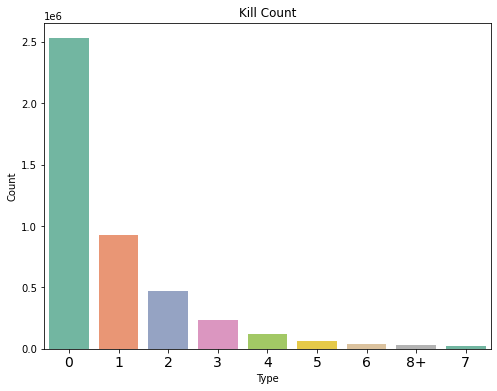

In [18]:
plt.figure(figsize=(8,6))
sns.barplot(x="Type", y="Count", data=train_ks, palette="Set2")
plt.xticks(fontsize=14)
plt.title("Kill Count")
plt.show()

- 대다수의 사람들이 0킬이나 1킬을 한것으로 보여진다

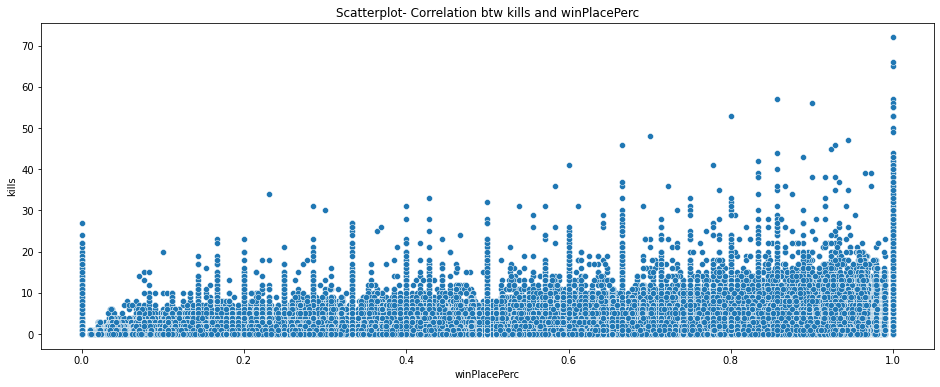

In [19]:
plt.figure(figsize=(16,6))
sns.scatterplot(data=train, x='winPlacePerc', y='kills')
plt.title("Scatterplot- Correlation btw kills and winPlacePerc")
plt.show()

- 킬수와 승리와의 상관관계는 존재한다
- 킬수가 높을수록 승리할 확률이 높다

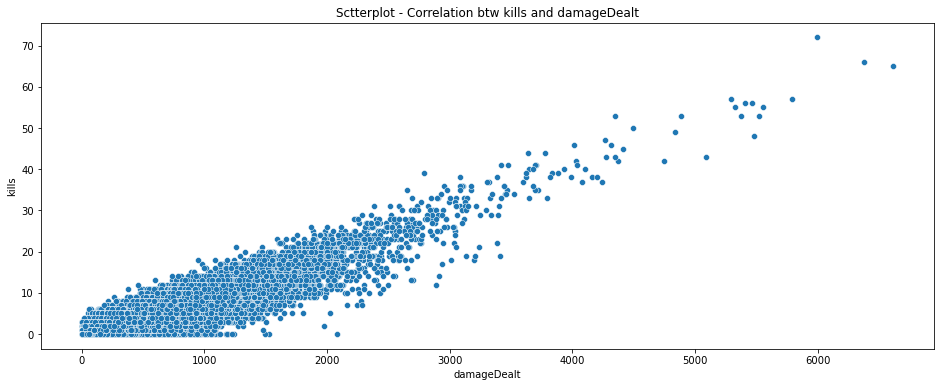

In [20]:
plt.figure(figsize=(16,6))
sns.scatterplot(data=train, x="damageDealt", y="kills")
plt.title("Sctterplot - Correlation btw kills and damageDealt")
plt.show()

- 킬수와 데미지는 양의 상관관계를 가진다 
- 킬수가 높을수록 데미지가 높다

In [21]:
train[train.kills>60]

,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
334400,f900de1ec39fa5,20,0,6616.0,0,13,5,1,0,65,...,0,0.0,0,0.0,0,0,1036.0,60,0,1.0
1248348,08e4c9e6c033e2,5,0,6376.0,0,21,4,1,0,66,...,0,0.0,0,0.0,0,0,1740.0,23,0,1.0
3431247,6680c7c3d17d48,7,4,5992.0,0,64,10,1,0,72,...,0,0.0,0,0.0,0,0,728.0,35,0,1.0


- 60킬 이상 한사람들의 데이터를 보면 걸은 거리가 그렇게 많지는 않은데 
- 한곳에 여러명이 떨어져서 그 지역에서 킬을 몰아서 먹은것으로 예상된다
- 아니면 불법 프로그램을 사용했을까?

In [22]:
train[(train['kills'] == 0) & (train['winPlacePerc'] == 1.0)]

,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
107,04832cfd74ff30,1,1,58.375000,0,0,2,38,0,0,...,0,5136.0,0,0.000,0,0,2708.0,7,0,1.0
118,c5d412db6dbee4,2,6,76.125000,0,0,12,45,0,0,...,1,0.0,0,0.000,0,0,2636.0,7,0,1.0
493,728a56582842f8,1,3,276.000000,0,0,2,44,0,0,...,0,2292.0,0,0.000,0,0,2536.0,4,0,1.0
1225,f8927d87063fd3,1,3,3.669922,0,0,3,36,1019,0,...,0,1298.0,0,0.000,0,0,1751.0,6,1511,1.0
1289,44fa051734f50f,2,2,126.812500,0,0,1,44,1337,0,...,0,0.0,0,0.000,0,0,1458.0,3,1550,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4445253,0070e0d3a110ab,1,3,125.625000,1,0,4,43,1509,0,...,0,807.0,0,0.000,0,0,2798.0,6,1476,1.0
4445751,bf63c9506132d0,1,3,124.687500,0,0,0,40,0,0,...,0,0.0,0,0.000,0,0,2252.0,6,0,1.0
4446093,0027b1ffb2e346,0,0,116.812500,0,0,0,3,0,0,...,0,0.0,0,0.000,0,0,0.0,11,0,1.0
4446823,b68a152e9ed994,0,3,49.500000,0,0,0,45,1639,0,...,0,0.0,0,0.000,0,0,4308.0,5,1623,1.0


In [23]:
train[(train['kills'] <= 1.0) & (train['winPlacePerc'] == 1.0)]

,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
107,04832cfd74ff30,1,1,58.375,0,0,2,38,0,0,...,0,5136.0,0,0.000,0,0,2708.0,7,0,1.0
118,c5d412db6dbee4,2,6,76.125,0,0,12,45,0,0,...,1,0.0,0,0.000,0,0,2636.0,7,0,1.0
341,12f3738af22f97,0,6,91.000,0,1,0,29,0,1,...,0,4428.0,0,0.000,0,0,2348.0,4,0,1.0
396,da92638f46258e,0,9,235.750,0,0,5,22,1427,1,...,3,4440.0,0,0.000,0,0,3408.0,9,1460,1.0
493,728a56582842f8,1,3,276.000,0,0,2,44,0,0,...,0,2292.0,0,0.000,0,0,2536.0,4,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446261,04bd0f78b5d348,1,6,133.750,1,0,13,22,1447,1,...,1,13800.0,0,0.000,0,0,2444.0,4,1649,1.0
4446639,7e4f1c489b9f39,0,2,302.000,2,1,4,18,0,1,...,0,5352.0,0,0.000,0,0,2300.0,6,0,1.0
4446823,b68a152e9ed994,0,3,49.500,0,0,0,45,1639,0,...,0,0.0,0,0.000,0,0,4308.0,5,1623,1.0
4446831,4ff3bccdadd120,0,5,208.750,1,0,3,35,0,0,...,0,3812.0,0,221.875,0,0,4588.0,6,0,1.0


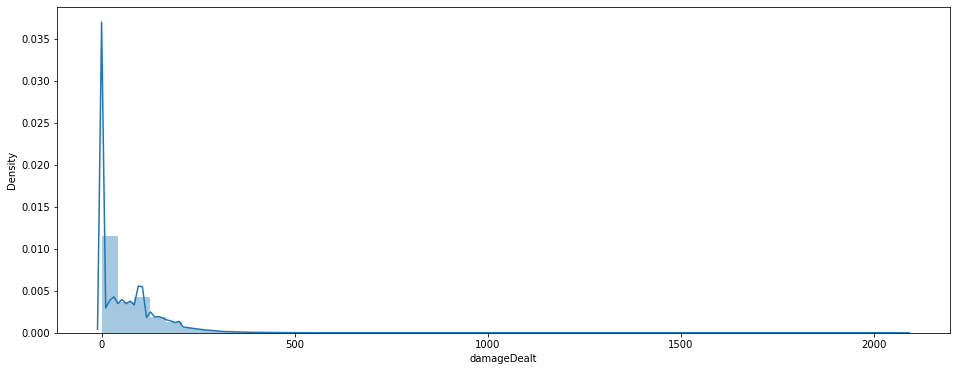

In [24]:
df = train.copy()
df = df[df['kills']<=1]

plt.figure(figsize=(16,6))
sns.distplot(df['damageDealt'])
plt.show()

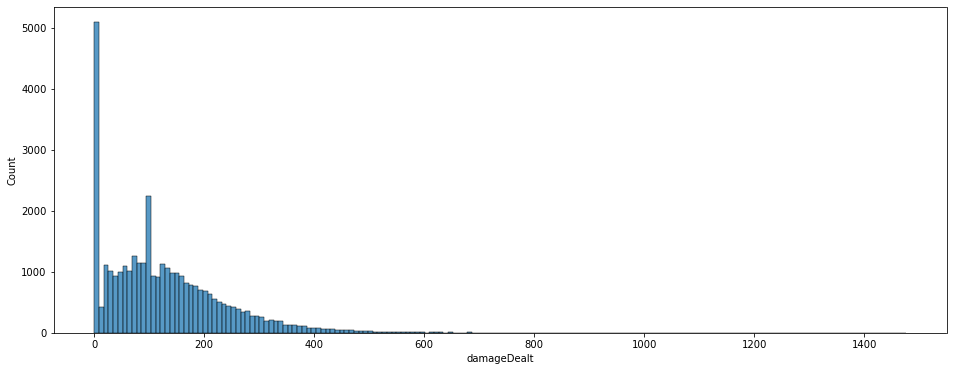

In [25]:
df = df[df['winPlacePerc'] == 1.0]
plt.figure(figsize=(16,6))
sns.histplot(data=df, x='damageDealt')
plt.show()

In [26]:
df1 = df[df['damageDealt']==0]
print(len(df), len(df1))

35349 4765


In [27]:
df1['matchType'].value_counts()

squad-fpp           2705
squad               1229
solo                 313
duo-fpp              297
duo                  125
normal-squad-fpp      70
crashfpp               9
normal-duo-fpp         6
normal-squad           3
crashtpp               3
solo-fpp               1
flaretpp               1
normal-duo             1
normal-solo            1
normal-solo-fpp        1
Name: matchType, dtype: int64

In [28]:
df1[df1['matchType'].str.contains('squad')]

,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2931,bbbed73da58547,0,2,0.0,0,0,0,46,1414,0,...,0,0.0,0,0.000000,0,0,2854.00000,5,1598,1.0
3114,1f78e2436506db,0,0,0.0,0,0,0,38,0,0,...,0,0.0,0,0.000000,0,0,18.65625,1,0,1.0
3571,2e3b45023dcb07,0,4,0.0,0,0,5,40,0,0,...,0,5632.0,0,0.000000,0,1,2440.00000,5,0,1.0
5288,f6d508a32b64c4,0,2,0.0,0,0,10,44,0,0,...,0,2868.0,0,0.000000,0,0,1385.00000,3,0,1.0
5910,2db42a79d10e2f,0,3,0.0,0,0,3,48,1165,0,...,0,0.0,0,57.250000,0,0,2348.00000,5,1504,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4438796,f91c0962c7f80c,0,0,0.0,0,0,0,45,0,0,...,0,5800.0,0,0.000000,0,0,1203.00000,6,0,1.0
4442844,f62ea2c15f1b94,0,1,0.0,0,0,0,32,0,0,...,0,0.0,0,0.000000,0,0,531.00000,2,0,1.0
4442954,25b5de34226272,0,0,0.0,0,0,0,28,0,0,...,0,0.0,0,0.000000,0,0,575.50000,4,0,1.0
4443682,1ceae175e4f52b,1,5,0.0,0,0,2,37,1030,0,...,2,880.0,0,0.000000,0,0,3998.00000,9,1487,1.0


In [29]:
df1[df1['matchType'].str.contains('duo')]

,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
8816,5fd08ef41cd102,2,2,0.0,0,0,0,40,0,0,...,0,0.000000,0,0.000000,0,0,2628.0,6,0,1.0
19925,e3861cea32972c,0,4,0.0,0,0,3,17,1267,0,...,0,0.000000,0,0.000000,0,0,3672.0,4,1542,1.0
27196,4170854e34eaa2,0,3,0.0,0,0,6,37,0,0,...,0,0.000000,0,0.000000,0,0,2882.0,6,0,1.0
30235,12f3738af22f97,0,1,0.0,0,0,0,38,0,0,...,0,4672.000000,0,0.000000,0,0,2144.0,4,0,1.0
31618,b1ec156807d332,0,4,0.0,0,0,0,44,0,0,...,0,0.000000,0,0.000000,0,0,3610.0,6,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4391594,6a317beb2a70f8,1,5,0.0,0,0,7,39,0,0,...,0,6524.000000,0,0.000000,0,0,3604.0,7,0,1.0
4394774,53967fca8e9242,0,4,0.0,0,0,0,41,1214,0,...,0,0.012001,0,6.261719,0,0,5040.0,4,1508,1.0
4404200,6f87581f0234ae,1,4,0.0,0,0,4,34,1068,0,...,0,798.000000,0,0.000000,0,0,2702.0,8,1542,1.0
4410111,030eff2bfd4ad1,0,0,0.0,0,0,0,37,1075,0,...,0,0.000000,0,0.000000,0,0,3802.0,4,1560,1.0


In [30]:
df1[df1['matchType'].str.contains('solo')]

,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
3702,01aead02bb8901,0,0,0.0,0,0,0,1,0,0,...,0,0.0,0,0.0,0,0,0.0,3,0,1.0
8790,cf0cb51c829eb5,0,0,0.0,0,0,0,2,0,0,...,0,0.0,0,0.0,0,0,0.0,1,0,1.0
18426,486200c5613f14,0,1,0.0,0,0,0,2,0,0,...,0,0.0,0,0.0,0,0,0.0,6,0,1.0
20114,cfd78a55ab6674,0,0,0.0,0,0,0,1,0,0,...,0,0.0,0,0.0,0,0,0.0,6,0,1.0
29291,a8806a908405b4,0,0,0.0,0,0,0,1,0,0,...,0,0.0,0,0.0,0,0,0.0,4,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4427111,d079035fd0d627,0,0,0.0,0,0,0,3,0,0,...,0,0.0,0,0.0,0,0,0.0,2,0,1.0
4428430,0195fbe135716e,0,0,0.0,0,0,0,3,0,0,...,0,0.0,0,0.0,0,0,0.0,7,0,1.0
4428507,1b066b1bd0036f,0,0,0.0,0,0,0,3,0,0,...,0,0.0,0,0.0,0,0,0.0,18,0,1.0
4430451,8b1af8b54b0edb,0,0,0.0,0,0,0,2,0,0,...,0,0.0,0,0.0,0,0,0.0,0,0,1.0


In [31]:
df1['matchType'].str.contains('squad').sum()

4007

In [32]:
df1_squad = df1['matchType'].str.contains('squad').sum()
df1_duo = df1['matchType'].str.contains('duo').sum()
df1_solo = df1['matchType'].str.contains('solo').sum()
df1_mt = pd.DataFrame([df1_squad,df1_duo,df1_solo], index=["squad","duo","solo"], columns =["count"])
df1_mt

,count
squad,4007
duo,429
solo,316


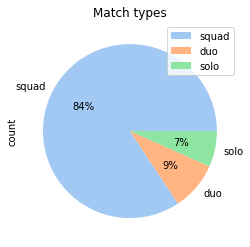

In [33]:
palette = sns.color_palette('pastel')
df1_mt.plot.pie(y="count", colors=palette, autopct='%.0f%%');
plt.title("Match types")
plt.show()

- 데미지가 0으로 우승한 사람들은 squad가 대부분이다
- 솔로에서 데미지가 0으로 우승한 사람들 316명은 핵으로 취급하거나
- 운이 좋아서 아무것도 안하고 이겼다고 볼수있을거 같다 (e.g. 마지막 한명이 자기장밖에서 죽거나, 마지막 두명이 서로 싸우다 자멸하거나)

- 킬수와 승리의 상관관계는 존재한다
- 킬수가 높을수록 승리를 할 확률이 높다
- 킬수와 데미지의 상관관계는 존재한다
- 킬수가 높을수록 데미지가 높다
- 킬수가 낮거나 없는 사람들중에 승리한 사람들은 좋은 팀을 만나 승리한것으로 보여진다
- 킬수가 낮거나 없는 사람들중에 승리한 사람들은 데미지를 제대로 주지 못한것으로 보여진다
- 그야말로 팀원 덕분에 승리한거라고 할수있다

##### Assists

In [34]:
train_group['assists'].quantile(0.99)

3.0

In [35]:
train_group['assists'].value_counts()

0     2978830
1      553245
2      134856
3       35260
4        9812
5        2801
6         920
7         338
8         157
9          68
10         38
11         17
12         12
13         10
15          5
14          2
17          1
Name: assists, dtype: int64

In [36]:
assists= train_group.copy()
assists.loc[assists['assists'] >= 4] = '4+'
train_ast = assists.loc[:,"assists"].value_counts().to_frame().reset_index()
train_ast.columns = ["Type","Count"]
train_ast

,Type,Count
0,0,2978830
1,1,553245
2,2,134856
3,3,35260
4,4+,14181


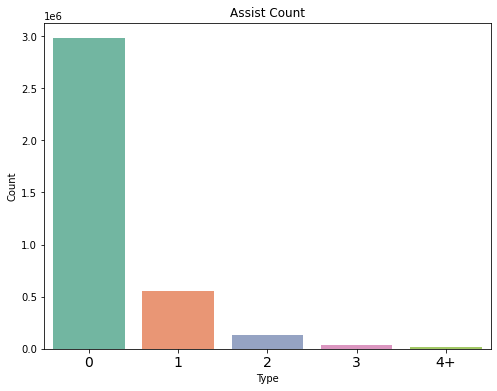

In [37]:
plt.figure(figsize=(8,6))
sns.barplot(x="Type", y="Count", data=train_ast, palette="Set2")
plt.xticks(fontsize=14)
plt.title("Assist Count")
plt.show()

- 대다수가 0에서 1 어시스트를 했다

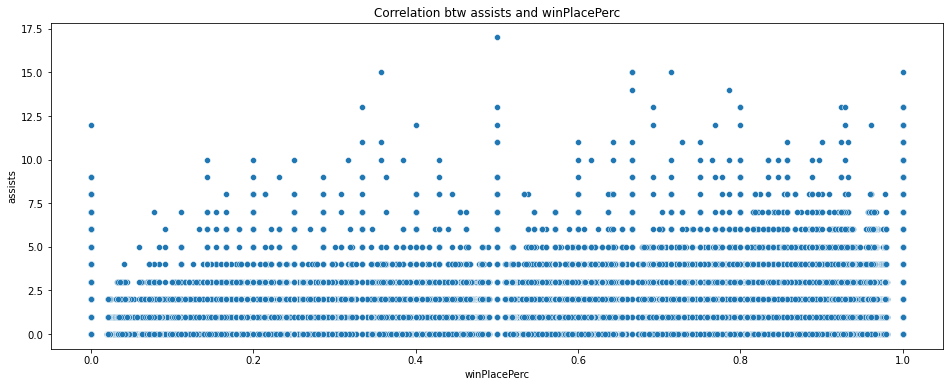

In [38]:
plt.figure(figsize=(16,6))
sns.scatterplot(data=train_group, x='winPlacePerc', y='assists')
plt.title("Correlation btw assists and winPlacePerc")
plt.show()

- 어시스트와 승리와의 뚜렷한 상관관계는 보이지 않는것 같다

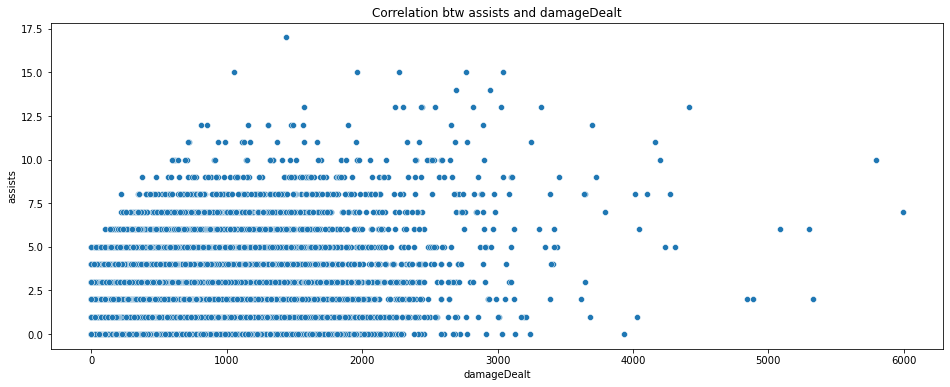

In [39]:
plt.figure(figsize=(16,6))
sns.scatterplot(data=train_group, x='damageDealt', y='assists')
plt.title("Correlation btw assists and damageDealt")
plt.show()

- 어시스트와 데미지와의 뚜렷한 상관관계는 보이지 않는것 같다

### DBNOS & headshotKills & LongestKill & Killstreaks & teamKills

#### DBNOs

In [40]:
train_group['DBNOs'].quantile(0.99)

5.0

In [41]:
train_group.DBNOs.value_counts()

0     2046858
1      980807
2      394313
3      162429
4       69210
5       31645
6       14959
7        7282
8        3686
9        1962
10       1109
11        642
12        465
13        274
14        177
15        137
16         87
17         79
18         64
19         33
20         30
21         25
22         18
25         16
23         14
26         11
24         10
33          7
27          6
32          3
31          3
28          3
39          2
38          1
30          1
29          1
35          1
40          1
53          1
Name: DBNOs, dtype: int64

In [42]:
dbnos = train_group.copy()
dbnos.loc[dbnos['DBNOs'] >= 6] = '6+'
train_dbnos = dbnos.loc[:,"DBNOs"].value_counts().to_frame().reset_index()
train_dbnos.columns = ["Type","Count"]
train_dbnos

,Type,Count
0,0,2046858
1,1,980807
2,2,394313
3,3,162429
4,4,69210
5,5,31645
6,6+,31110


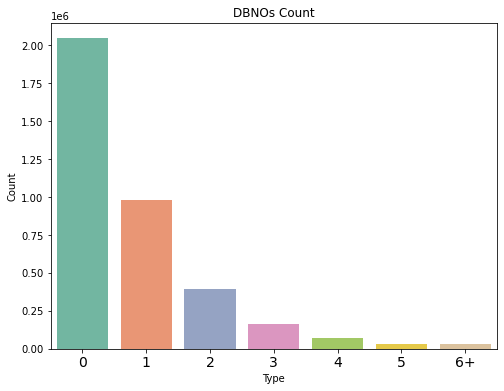

In [43]:
plt.figure(figsize=(8,6))
sns.barplot(x="Type", y="Count", data=train_dbnos, palette="Set2")
plt.xticks(fontsize=14)
plt.title("DBNOs Count")
plt.show()

In [44]:
train_group['DBNOs'].describe()

count    3.716372e+06
mean     7.856420e-01
std      1.211465e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      5.300000e+01
Name: DBNOs, dtype: float64

In [45]:
train_group['DBNOs'].mean()

0.7856420186138524

- 기절시킨 적의 평균수는 0.79이고, 대부분의 사람들이 기절도 못시켰다 

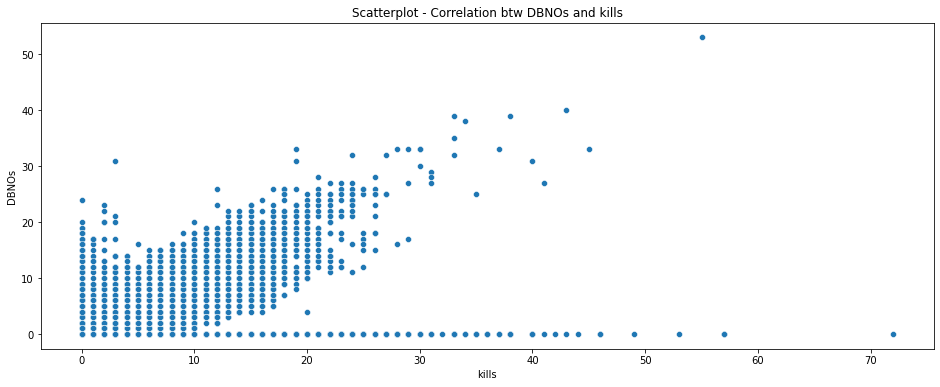

In [46]:
plt.figure(figsize=(16,6))
sns.scatterplot(data=train_group, x ="kills", y="DBNOs")
plt.title("Scatterplot - Correlation btw DBNOs and kills")
plt.show()

- 기절시킨 적의 수와 킬수간에는 양의 상관관계를 가진다
- 기절시킨 적의 수가 높을수록 킬로 마무리를 한것으로 보여진다

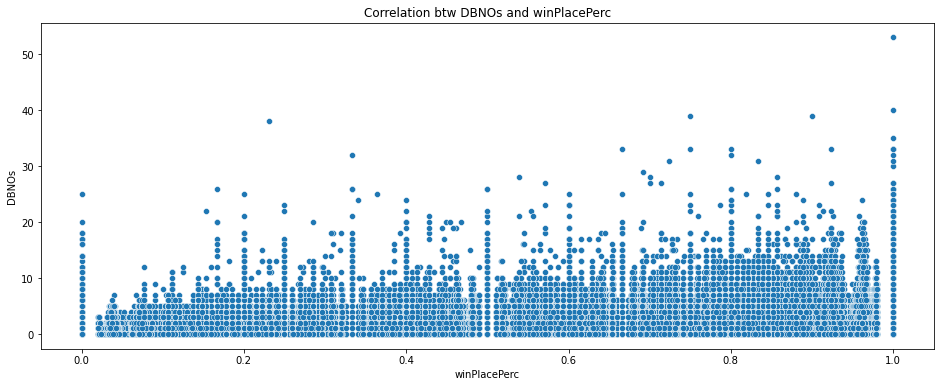

In [47]:
plt.figure(figsize=(16,6))
sns.scatterplot(data=train_group, x ="winPlacePerc", y="DBNOs")
plt.title("Correlation btw DBNOs and winPlacePerc")
plt.show()

- 기절시킨 적의 수와 승리간에는 어느정도 양의 상관관계를 가지는것 같다
- 대다수의 사람들이 기절도 못시켰던것으로 보인다 

#### HeadshotKills

In [48]:
train['headshotKills'].quantile(0.99)

3.0

In [49]:
train['headshotKills'].value_counts()

0     3696115
1      574741
2      126348
3       32975
4        9962
5        3616
6        1439
7         757
8         373
9         215
10        136
11         79
12         64
13         44
14         23
15         16
16         15
17         11
18          9
19          3
23          3
20          3
26          3
31          2
34          2
27          2
21          2
41          1
64          1
40          1
39          1
46          1
42          1
35          1
Name: headshotKills, dtype: int64

In [50]:
headshot = train.copy()
headshot.loc[headshot['headshotKills'] >= 4] = '4+'
train_headshot = headshot.loc[:,"headshotKills"].value_counts().to_frame().reset_index()
train_headshot.columns = ["Type","Count"]
train_headshot

,Type,Count
0,0,3696115
1,1,574741
2,2,126348
3,3,32975
4,4+,16786


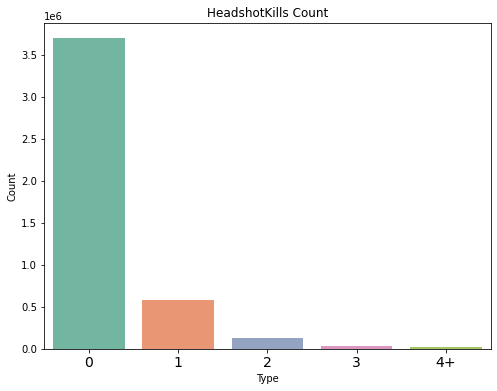

In [51]:
plt.figure(figsize=(8,6))
sns.barplot(x="Type", y="Count", data=train_headshot, palette="Set2")
plt.xticks(fontsize=14)
plt.title("HeadshotKills Count")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

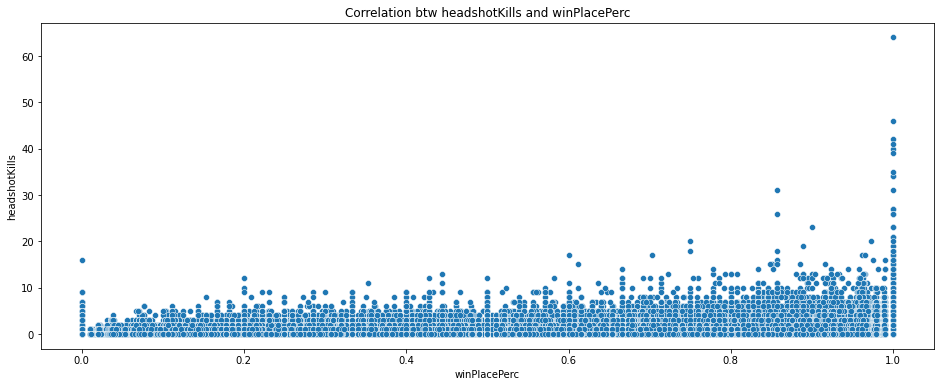

In [52]:
plt.figure(figsize=(16,6))
sns.scatterplot(data=train, x="winPlacePerc", y="headshotKills", palette="Set2")
plt.title("Correlation btw headshotKills and winPlacePerc")
plt.show

- 뚜렷한 상관관계는 보이지 않는다

#### Longestkill

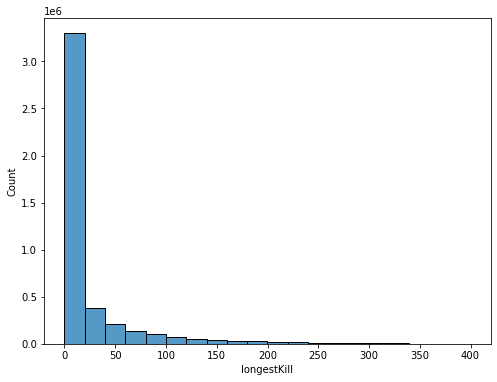

In [53]:
range = train[train['longestKill']<400]
plt.figure(figsize=(8,6))
sns.histplot(data=range, x='longestKill', bins=20)
plt.show()

In [54]:
train['longestKill'].describe()

count    4.446965e+06
mean              NaN
std               NaN
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.131250e+01
max      1.094000e+03
Name: longestKill, dtype: float64

In [55]:
train[train['longestKill'] == 0]

,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,a10357fd1a4a91,0,0,0.00000,0,0,0,60,1241,0,...,0,0.000000,0,0.000000,0,0,244.7500,1,1466,0.444336
1,aeb375fc57110c,0,0,91.50000,0,0,0,57,0,0,...,0,0.004501,0,11.039062,0,0,1434.0000,5,0,0.640137
2,110163d8bb94ae,1,0,68.00000,0,0,0,47,0,0,...,0,0.000000,0,0.000000,0,0,161.7500,2,0,0.775391
3,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,0,0,...,0,0.000000,0,0.000000,0,0,202.7500,3,0,0.166748
6,a8274e903927a2,0,0,0.00000,0,0,0,96,1262,0,...,0,0.000000,0,0.000000,0,0,13.5000,1,1497,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446958,2001300d4f5787,0,0,0.00000,0,0,0,92,0,0,...,0,0.000000,0,0.000000,0,0,0.0000,0,0,0.000000
4446959,2f3b1af94739b3,0,0,22.68750,0,0,0,89,0,0,...,0,0.000000,0,0.000000,0,0,40.2500,1,0,0.084229
4446961,18492834ce5635,0,0,0.00000,0,0,0,74,1029,0,...,0,1292.000000,0,0.000000,0,0,1019.0000,3,1507,0.178589
4446962,ee854b837376d9,0,1,44.15625,0,0,0,69,0,0,...,0,0.000000,0,0.000000,0,0,81.6875,6,0,0.293457


- 킬을 할때까지 최대의 거리는 1094m이다
- 킬을 할때까지 거리의 평균은 23m이다
- 킬을 할때까지 거리가 0인 값들은 nan값을 0으로 전처리 해줬을 가능성이 있다

#### KIllStreaks

In [56]:
train['killStreaks'].quantile(0.99)

3.0

In [57]:
train['killStreaks'].value_counts()

0     2529721
1     1475558
2      389346
3       45958
4        5711
5         409
6         126
7          54
8          32
9          18
10          9
11          8
13          5
12          5
14          2
16          1
18          1
20          1
Name: killStreaks, dtype: int64

In [58]:
streaks = train.copy()
streaks.loc[streaks['killStreaks'] >= 4] = '4+'
train_streaks = streaks.loc[:,"killStreaks"].value_counts().to_frame().reset_index()
train_streaks.columns = ["Type","Count"]
train_streaks

,Type,Count
0,0,2529721
1,1,1475558
2,2,389346
3,3,45958
4,4+,6382


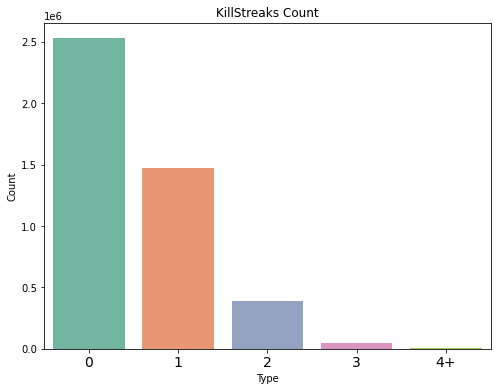

In [59]:
plt.figure(figsize=(8,6))
sns.barplot(x="Type", y="Count", data=train_streaks, palette="Set2")
plt.xticks(fontsize=14)
plt.title("KillStreaks Count")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

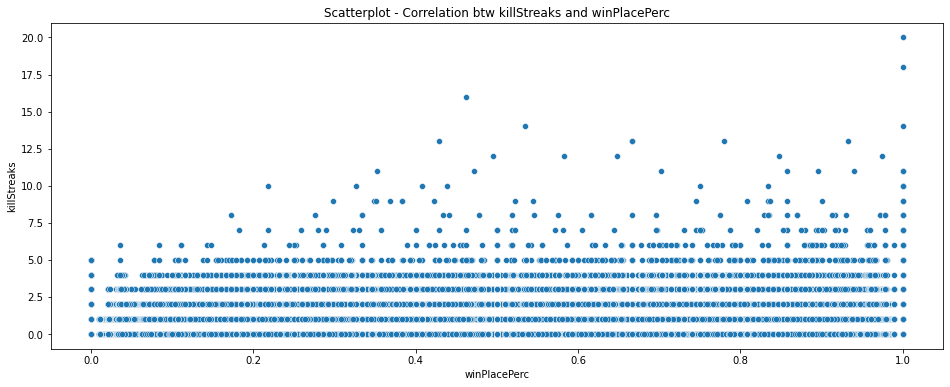

In [60]:
plt.figure(figsize=(16,6))
sns.scatterplot(data=train, x="winPlacePerc", y="killStreaks", palette="Set2")
plt.title("Scatterplot - Correlation btw killStreaks and winPlacePerc")
plt.show

- 짧은 시간내에 적을 죽인 수가 많을수록 승리할 확률이 높아지는것 같다 

#### teamKills

In [61]:
train_group['teamKills'].quantile(0.99)

1.0

In [62]:
train_group['teamKills'].value_counts()

0     3628318
1       79933
2        7203
3         826
4          80
5           6
10          2
7           1
12          1
6           1
8           1
Name: teamKills, dtype: int64

In [63]:
teamKills = train.copy()
teamKills.loc[teamKills['teamKills'] >= 4] = '4+'
train_tks= teamKills.loc[:,"teamKills"].value_counts().to_frame().reset_index()
train_tks.columns = ["Type","Count"]
train_tks

,Type,Count
0,0,4350035
1,1,88771
2,2,7236
3,3,829
4,4+,94


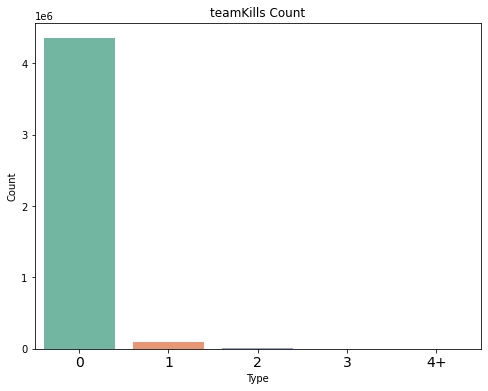

In [64]:
plt.figure(figsize=(8,6))
sns.barplot(x="Type", y="Count", data=train_tks, palette="Set2")
plt.xticks(fontsize=14)
plt.title("teamKills Count")
plt.show()

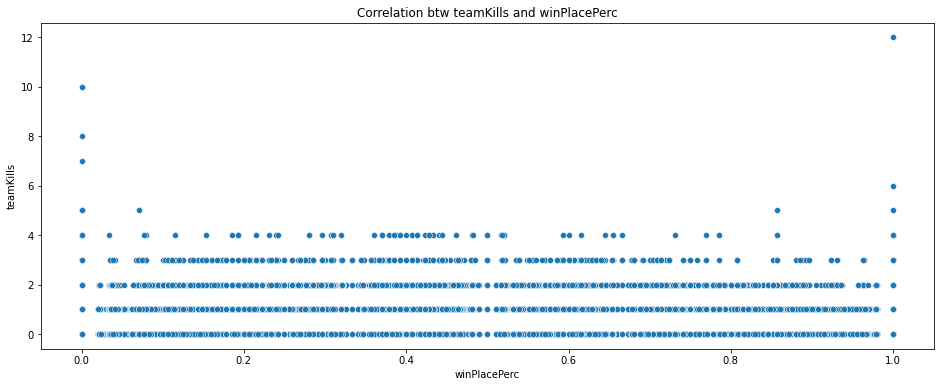

In [65]:
plt.figure(figsize=(16,6))
sns.scatterplot(data=train_group, x='winPlacePerc', y='teamKills')
plt.title("Correlation btw teamKills and winPlacePerc")
plt.show()

- teamkill의 수가 거의 없어서 승리와의 상관관계는 없다고 보여진다

### Heals & Boosts

In [66]:
heals = train['heals'].quantile(0.99)
boosts = train['boosts'].quantile(0.99)
print(heals, boosts)

12.0 7.0


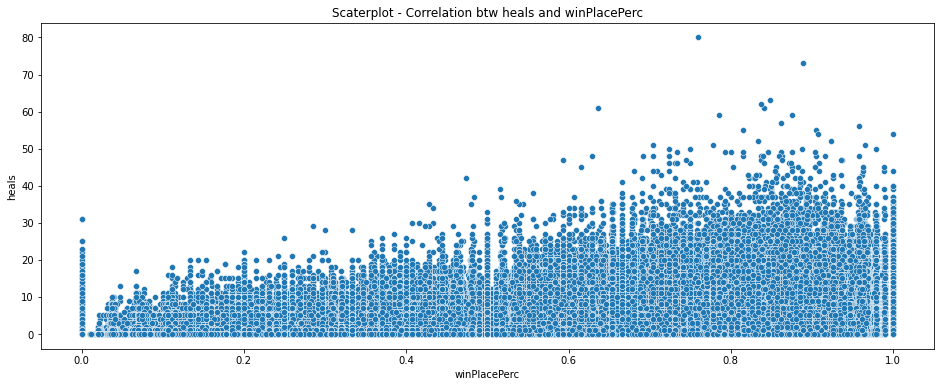

In [67]:
plt.figure(figsize=(16,6))
sns.scatterplot(data=train, x='winPlacePerc', y='heals')
plt.title("Scaterplot - Correlation btw heals and winPlacePerc")
plt.show()

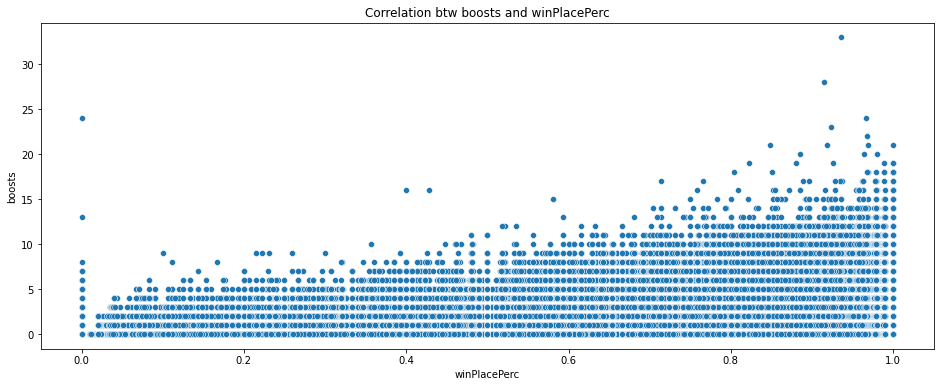

In [68]:
plt.figure(figsize=(16,6))
sns.scatterplot(data=train, x='winPlacePerc', y='boosts')
plt.title("Correlation btw boosts and winPlacePerc")
plt.show()

In [69]:
train[['heals', 'boosts']].describe()

,heals,boosts
count,4.446965e+06,4.446965e+06
mean,1.370148e+00,1.106908e+00
std,2.679982e+00,1.715794e+00
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00
75%,2.000000e+00,2.000000e+00
max,8.000000e+01,3.300000e+01


- Heals와 boosts 모두 양의 상관관계를 보인다
- Heals 평균 사용 횟수는 1.3이고, 대다수의 사람들이 하나도 사용하지 못했다 
- Boosts 평균 사용 횟수는 1.1이고, 대다수의 사람들이 하나도 사용하지 못했다
- 이는, 시작하자 마자 죽어서 아이템들을 사용할 기회가 없었던 것으로 예상된다

### WalkDistance & SwimDistance & RideDistance & WeaponAcquired

#### walkDistance

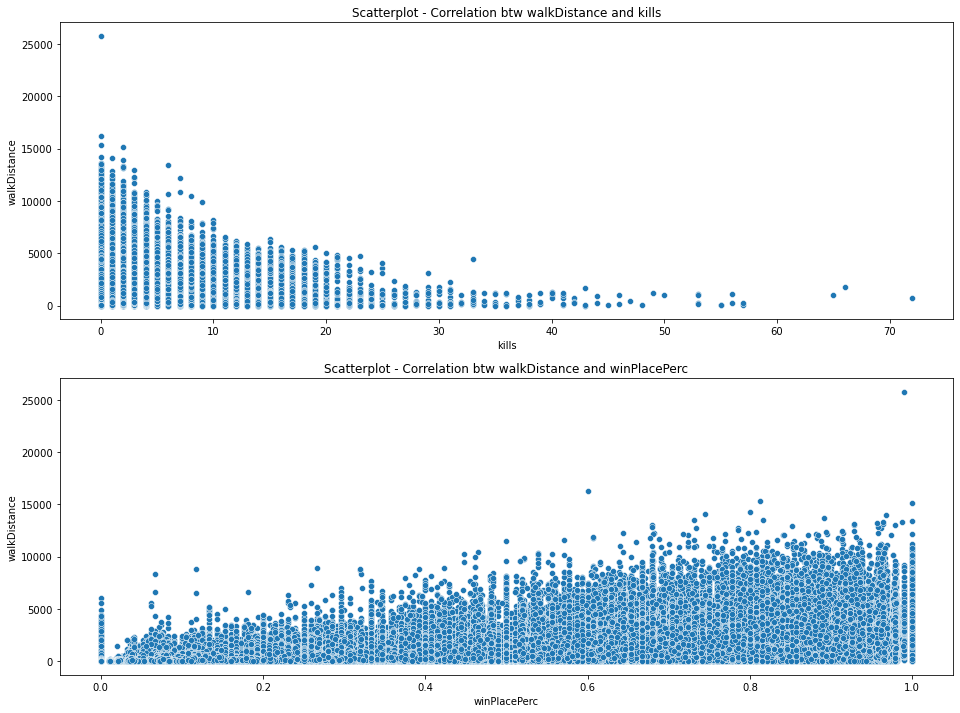

In [70]:
plt.figure(figsize=(16,12))
plt.subplot(211)
sns.scatterplot(data=train, x='kills', y='walkDistance')
plt.title("Scatterplot - Correlation btw walkDistance and kills")
plt.subplot(212)
sns.scatterplot(data=train, x='winPlacePerc', y='walkDistance')
plt.title("Scatterplot - Correlation btw walkDistance and winPlacePerc")
plt.show()

- 걸은 거리가 많을수록 킬수가 높은것만은 아닌것으로 보여진다
- 오히려 걸은 거리가 적은 사람들중에 킬수가 많은 사람들이 많은 것으로 보여진다
- 걸은 거리와 승률과의 관계에서 어느정도 양의 상관관계를 보인다

In [71]:
train[train['walkDistance'] > 20000][['maxPlace','matchType', 'walkDistance', 'swimDistance', 'rideDistance', 'winPlacePerc']]

,maxPlace,matchType,walkDistance,swimDistance,rideDistance,winPlacePerc
497965,95,solo-fpp,25776.0,382.0,0.007801,0.989258


- 걸은 거리가 25780.0인 사람은 걷거나 수영만 했고 아이템을 파밍하지도 않았고 아무도 안만나서 데미지도 없는 것으로 보아 맵탐방을 하지 않았을까 예상이된다 
- 그럼에도 불구하고 승리는 못했지만 높은 등수를 차지한것으로 보인다

##### 이동하지 않았는데 아이템을 획득한 사람들

In [72]:
train[(train.walkDistance == 0) & (train.weaponsAcquired != 0)][['walkDistance', 'weaponsAcquired', 'damageDealt', 'kills']]

,walkDistance,weaponsAcquired,damageDealt,kills
711,0.0,1,0.0000,0
846,0.0,6,0.0000,0
1357,0.0,15,723.0000,0
1433,0.0,1,85.6250,0
1814,0.0,1,0.0000,0
...,...,...,...,...
4446464,0.0,1,0.0000,0
4446682,0.0,4,41.9375,1
4446786,0.0,1,0.0000,0
4446812,0.0,1,0.0000,0


In [73]:
train['matchType'].value_counts()

squad-fpp           1756186
duo-fpp              996691
squad                626526
solo-fpp             536761
duo                  313591
solo                 181943
normal-squad-fpp      17174
crashfpp               6287
normal-duo-fpp         5489
flaretpp               2505
normal-solo-fpp        1682
flarefpp                718
normal-squad            516
crashtpp                371
normal-solo             326
normal-duo              199
Name: matchType, dtype: int64

In [74]:
train[(train.walkDistance == 0) & (train.kills >= 2)][['maxPlace', 'matchType', 'walkDistance', 'weaponsAcquired', 'damageDealt', 'kills']]

,maxPlace,matchType,walkDistance,weaponsAcquired,damageDealt,kills
1824,15,normal-squad-fpp,0.0,8,593.000,6
6673,11,normal-squad-fpp,0.0,22,346.500,3
11892,20,normal-solo-fpp,0.0,13,1750.000,20
20881,6,normal-squad,0.0,8,506.000,6
23298,6,normal-squad-fpp,0.0,8,1124.000,12
...,...,...,...,...,...,...
4429697,6,normal-squad-fpp,0.0,31,645.500,5
4436511,6,normal-squad-fpp,0.0,8,221.625,5
4437516,14,normal-squad-fpp,0.0,24,361.750,5
4440927,11,normal-squad-fpp,0.0,7,909.000,6


- 이사람들은 불법 프로그램 사용자들일까?
- 낙하산에서 내리자마자 그자리에 아이템이 있어서 먹을 수도 있지만, 움직이지도 않고 킬을 여러개(1킬이상) 한것은 의심스러워 보인다 

#### swimDistance

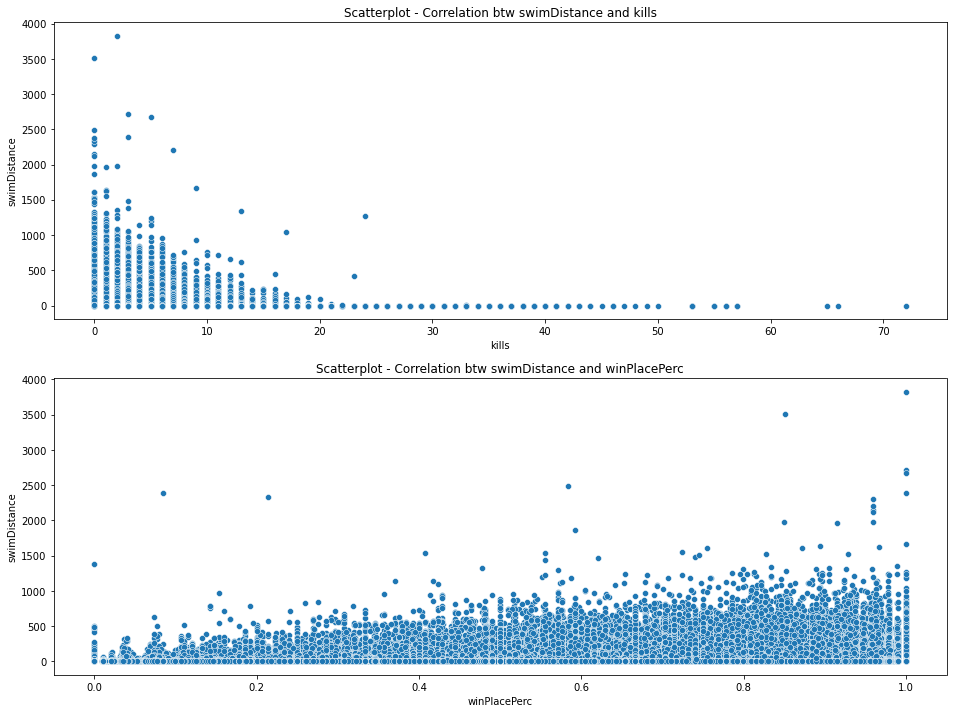

In [75]:
plt.figure(figsize=(16,12))
plt.subplot(211)
sns.scatterplot(data=train, x='kills', y='swimDistance')
plt.title("Scatterplot - Correlation btw swimDistance and kills")
plt.subplot(212)
sns.scatterplot(data=train, x='winPlacePerc', y='swimDistance')
plt.title("Scatterplot - Correlation btw swimDistance and winPlacePerc")
plt.show()

- 수영한 거리와 킬과의 상관관계는 음의 상관관계를 가진다
- 수영한 거리와 승리와의 상관관계는 양의 상관관계를 가진다 

#### rideDistance

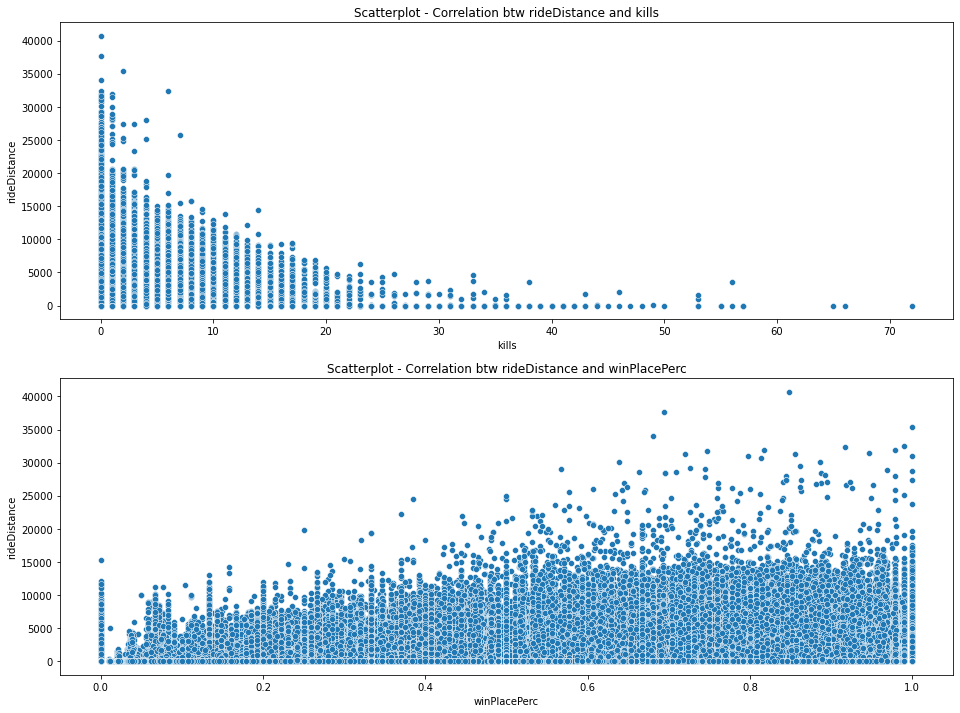

In [76]:
plt.figure(figsize=(16,12))
plt.subplot(211)
sns.scatterplot(data=train, x='kills', y='rideDistance')
plt.title("Scatterplot - Correlation btw rideDistance and kills")
plt.subplot(212)
sns.scatterplot(data=train, x='winPlacePerc', y='rideDistance')
plt.title("Scatterplot - Correlation btw rideDistance and winPlacePerc")
plt.show()

- 이동수단으로 이동한 거리와 킬과의 상관관계는 음의 상관관계를 가진다
- 이동수단으로 이동한 거리와 승리와의 상관관계는 양의 상관관계를 가진다 

#### weaponsAcquired

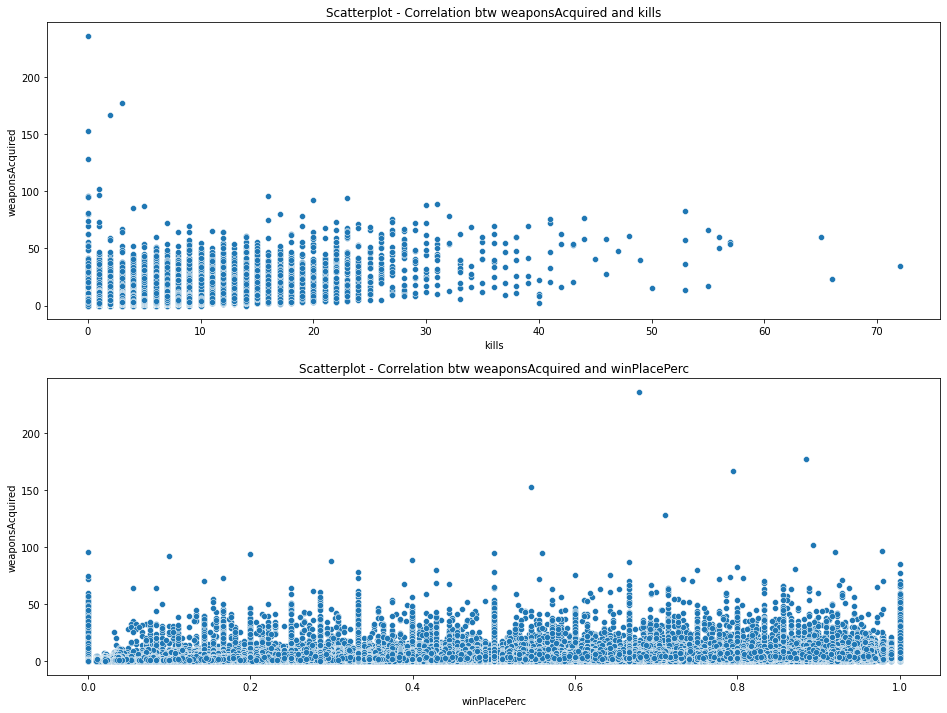

In [77]:
plt.figure(figsize=(16,12))
plt.subplot(211)
sns.scatterplot(data=train, x='kills', y='weaponsAcquired')
plt.title("Scatterplot - Correlation btw weaponsAcquired and kills")
plt.subplot(212)
sns.scatterplot(data=train, x='winPlacePerc', y='weaponsAcquired')
plt.title("Scatterplot - Correlation btw weaponsAcquired and winPlacePerc")
plt.show()

- 아이템 획득수와 킬 또는 승리와의 뚜렷한 상관관계는 보이지 않는다

##### 무기없이 주먹으로 킬한 사람들

In [78]:
train[(train.weaponsAcquired == 0) & (train.kills != 0)]

,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
1627,9a70b0ea4aeb41,0,0,100.000000,1,0,0,38,1104,1,...,0,0.00,0,0.0,0,0,45.968750,0,1521,0.321289
3946,04de3bdc8540a7,0,0,100.000000,0,0,0,43,0,1,...,0,0.00,0,0.0,0,0,32.906250,0,0,0.177124
7259,681b7e6ea05b36,0,0,200.000000,5,2,0,14,0,2,...,0,259.25,0,0.0,3,0,177.250000,0,0,0.119995
7559,493f437b8ff573,0,0,100.000000,1,0,0,37,0,1,...,0,0.00,0,0.0,0,0,116.687500,0,0,0.083313
8103,9541d38c78fa96,0,0,100.000000,1,1,0,43,0,1,...,0,0.00,0,0.0,0,0,25.546875,0,0,0.021301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4441281,ed5d47d80ac351,0,0,300.000000,2,0,0,4,0,3,...,0,7772.00,3,0.0,0,0,125.875000,0,0,0.915039
4444332,e31dadd8f4ca23,0,0,100.000000,1,1,0,37,1000,1,...,0,0.00,0,0.0,0,0,4.265625,0,1500,0.020798
4444788,aa6a6a2264ec4b,0,0,100.000000,1,0,0,29,0,1,...,0,1286.00,1,0.0,0,0,154.250000,0,0,0.500000
4445403,4fdab3b35454bd,0,0,11.601562,1,0,0,33,0,1,...,0,0.00,0,0.0,0,0,256.500000,0,0,0.119995


In [79]:
print(len(train[(train.weaponsAcquired == 0) & (train.kills != 0)]))

3310


- 무기를 획득하지 않고 kill수를 획득한 사람들(3310)은 주먹으로 싸워서 이긴것 같다 

### MatchType

In [80]:
train['matchType'].value_counts()

squad-fpp           1756186
duo-fpp              996691
squad                626526
solo-fpp             536761
duo                  313591
solo                 181943
normal-squad-fpp      17174
crashfpp               6287
normal-duo-fpp         5489
flaretpp               2505
normal-solo-fpp        1682
flarefpp                718
normal-squad            516
crashtpp                371
normal-solo             326
normal-duo              199
Name: matchType, dtype: int64

In [81]:
train_mt = train.loc[:,"matchType"].value_counts().to_frame().reset_index()
train_mt.columns = ["Type","Count"]
train_mt

,Type,Count
0,squad-fpp,1756186
1,duo-fpp,996691
2,squad,626526
3,solo-fpp,536761
4,duo,313591
5,solo,181943
6,normal-squad-fpp,17174
7,crashfpp,6287
8,normal-duo-fpp,5489
9,flaretpp,2505


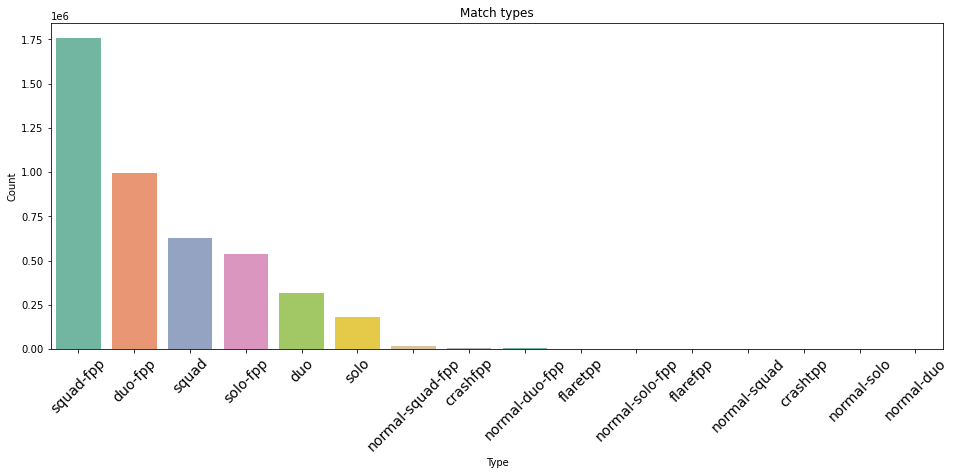

In [82]:
plt.figure(figsize=(16,6))
sns.barplot(x="Type", y="Count", data=train_mt, palette="Set2")
plt.xticks(rotation=45, fontsize=14)
plt.title("Match types")
plt.show()

- Squad-fpp 모드와 duo-fpp 모드가 제일 많은것으로 보인다

In [83]:
temp = train.loc[:,"matchType"].value_counts().to_frame()
squad = temp.loc[["squad-fpp","squad","normal-squad-fpp","normal-squad"],"matchType"].sum()
duo = temp.loc[["duo-fpp","duo","normal-duo-fpp","normal-duo"],"matchType"].sum()
solo = temp.loc[["solo-fpp","solo","normal-solo-fpp","normal-solo"],"matchType"].sum()
match_type = pd.DataFrame([squad,duo,solo], index=["squad","duo","solo"], columns =["count"])
match_type

,count
squad,2400402
duo,1315970
solo,720712


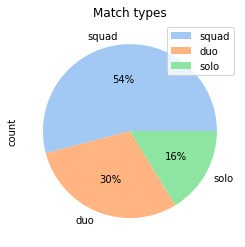

In [84]:
palette = sns.color_palette('pastel')
match_type.plot.pie(y="count", colors=palette, autopct='%.0f%%');
plt.title("Match types")
plt.show()

- Squad 경기수가 제일 많고 그다음으로 duo, solo로 많다.

In [85]:
# group_lists = ["squad-fpp","squad","duo-fpp","duo"]
# train_group = train.loc[train["matchType"].isin(group_lists)]
# solo_lists = ["solo-fpp","solo"]
# train_solo = train.loc[train["matchType"].isin(solo_lists)]

normal_lists = ["normal-suqad-fpp", "normal-duo-fpp", "normal-solo-fpp", "normal-squad", "normal-duo", "normal-solo"]
train_normal = train.loc[train["matchType"].isin(normal_lists)] 
crash = ["crashfpp","crashtpp"]
train_crash = train.loc[train["matchType"].isin(crash)] 
flare = ["flarefpp", "flaretpp"]
train_flare = train.loc[train["matchType"].isin(flare)] 

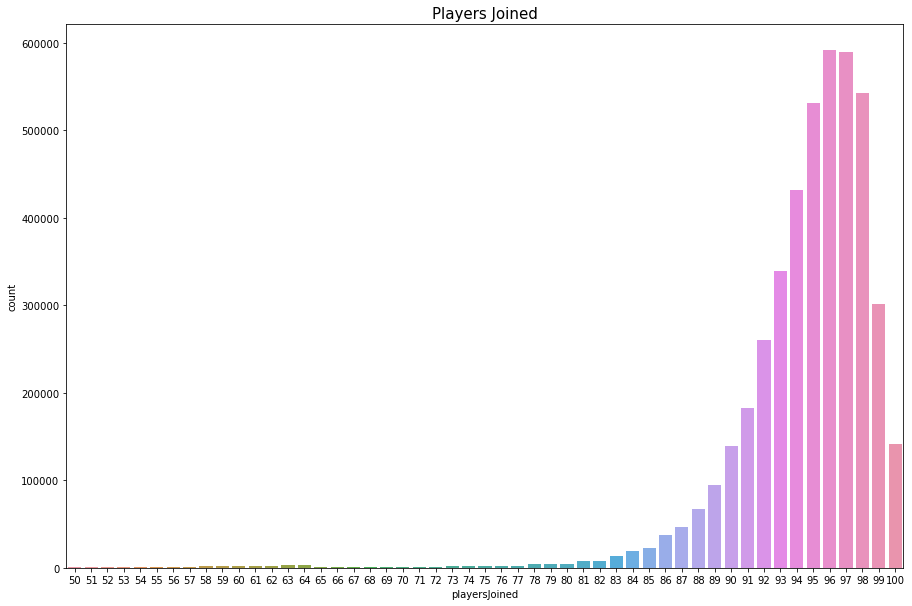

In [86]:
train['playersJoined'] = train.groupby('matchId')['matchId'].transform('count')
data = train.copy()
data = data[data['playersJoined']>49]
plt.figure(figsize=(15,10))
sns.countplot(data['playersJoined'])
plt.title("Players Joined",fontsize=15)
plt.show()

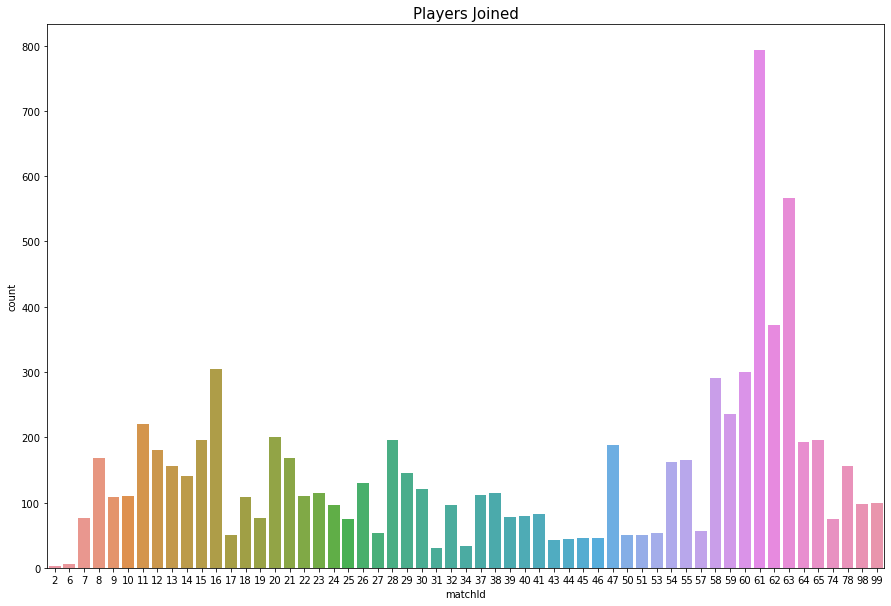

In [87]:
plt.figure(figsize=(15,10))
sns.countplot(train_normal.groupby('matchId')['matchId'].transform('count'))
plt.title("Players Joined",fontsize=15)
plt.show()

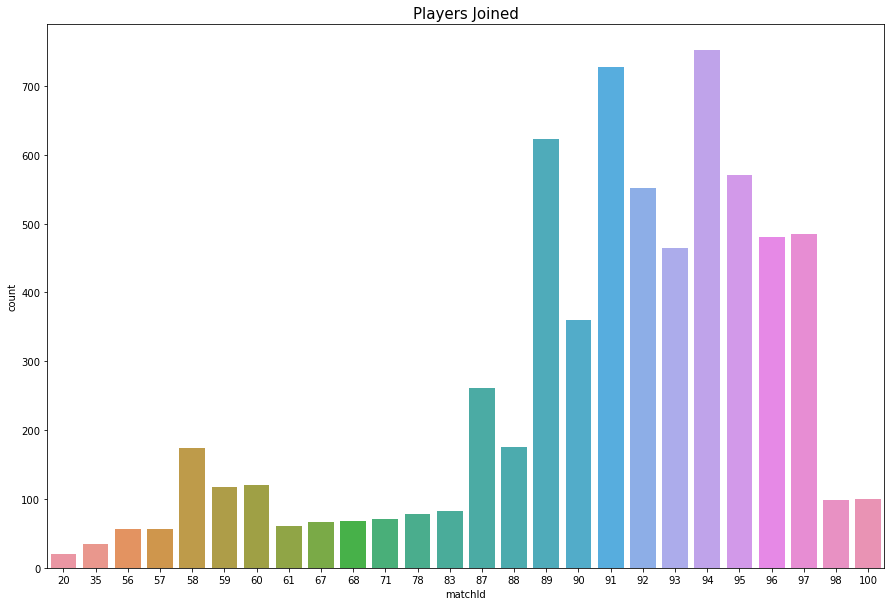

In [88]:
plt.figure(figsize=(15,10))
sns.countplot(train_crash.groupby('matchId')['matchId'].transform('count'))
plt.title("Players Joined",fontsize=15)
plt.show()

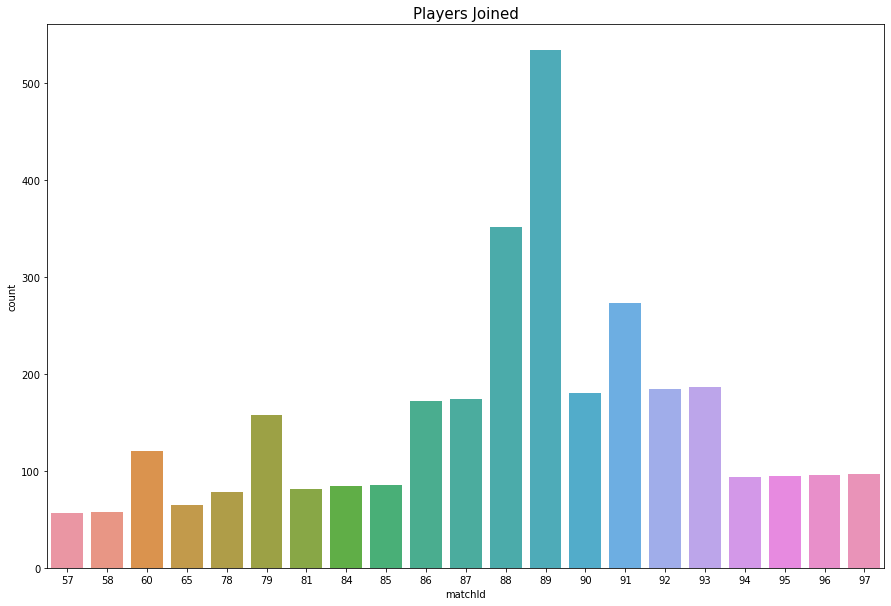

In [89]:
plt.figure(figsize=(15,10))
sns.countplot(train_flare.groupby('matchId')['matchId'].transform('count'))
plt.title("Players Joined",fontsize=15)
plt.show()

In [98]:
train[train['rankPoints'] == -1]

,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,...,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined
0,a10357fd1a4a91,0,0,0.000000,0,0,0,60,1241,0,...,0.0,0,0.00000,0,0,244.750,1,1466,0.444336,96
6,a8274e903927a2,0,0,0.000000,0,0,0,96,1262,0,...,0.0,0,0.00000,0,0,13.500,1,1497,0.000000,97
7,292611730ca862,0,0,8.539062,0,0,0,48,1000,0,...,2004.0,0,0.00000,0,0,1089.000,6,1500,0.736816,96
13,2c30ddf481c52d,0,1,324.250000,0,1,5,5,986,4,...,1228.0,0,76.81250,0,0,2050.000,6,1462,0.875000,97
14,94e1c1cc443c65,0,1,122.812500,1,0,2,25,1411,1,...,1237.0,0,60.28125,0,0,1666.000,5,1531,0.899902,93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446939,fa1b1885f56b7d,0,0,151.500000,1,0,0,35,1255,1,...,0.0,0,0.00000,0,0,56.125,1,1539,0.383057,96
4446948,05f6cd4077cd68,1,3,736.500000,4,1,2,7,1138,4,...,0.0,0,0.00000,0,0,1685.000,3,1500,0.791504,98
4446953,a530fd807f535a,0,0,30.093750,0,0,0,57,1364,0,...,0.0,0,0.00000,0,0,1025.000,5,1551,0.592773,95
4446954,deb3a91c03d0f3,0,0,30.093750,0,0,0,58,1007,0,...,0.0,0,0.00000,0,0,2146.000,6,1502,0.530762,99


## 전처리

### 상관관계와 다중공선성 확인

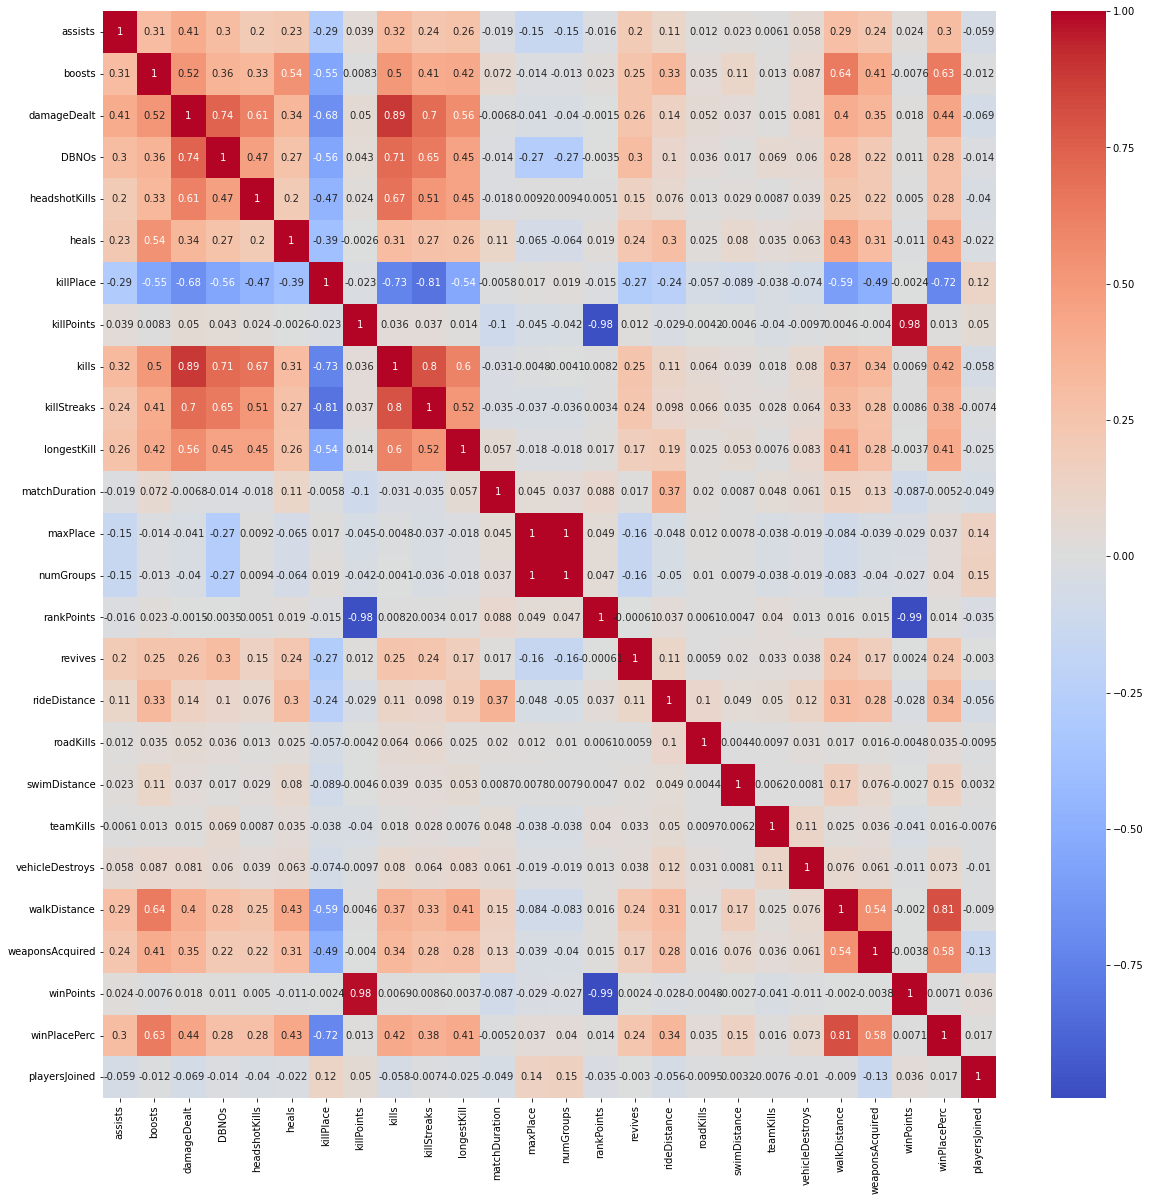

In [90]:
plt.figure(figsize=(20,20))
sns.heatmap(train.corr(),cmap='coolwarm',annot=True)
plt.show()

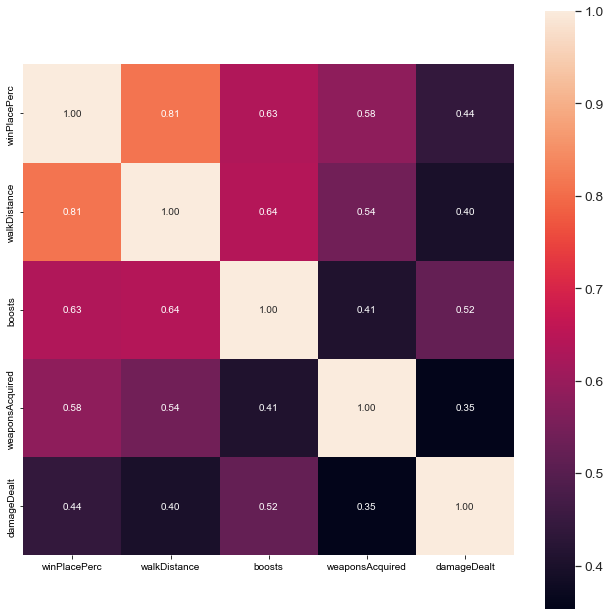

In [91]:
k = 5
f,ax = plt.subplots(figsize=(11, 11))
cols = train.corr().nlargest(k, 'winPlacePerc')['winPlacePerc'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

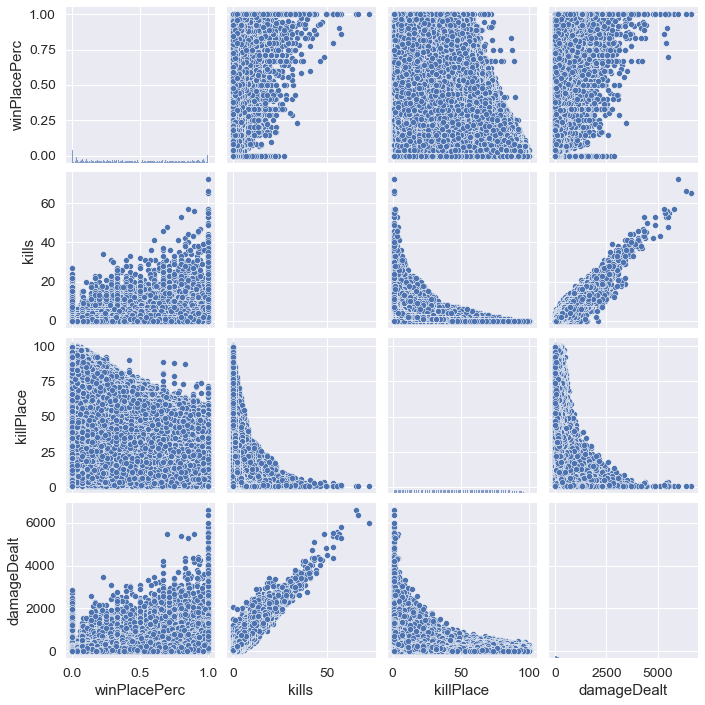

In [97]:
sns.pairplot(train[['winPlacePerc','kills','killPlace','damageDealt']]);

In [93]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# vif = pd.DataFrame()
# vif['VIF Factor'] = [variance_inflation_factor(train.values, i) for i in range(train.shape[1])]
# vif['features'] = train.columns
# vif

In [94]:
#train = train.drop([ "maxPlace", "rankPoints", "killPoints"], axis=1)

In [95]:
#train = train.drop([ "killPlace", "damageDealt"], axis=1)

In [116]:
import numpy as np
import pandas as pd
import gc
import lightgbm as lgb

#print("Read Done")
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    # iterate through all the columns of a dataframe and modify the data type
    #   to reduce memory usage.        
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df





def featureModify(isTrain):
    if isTrain:
        all_data = pd.read_csv('./data/pubg-finish-placement-prediction/train_V2.csv') 
        all_data = all_data[all_data['maxPlace'] > 1]
        all_data = reduce_mem_usage(all_data)
        all_data = all_data[all_data['winPlacePerc'].notnull()]
    else:
        all_data = pd.read_csv('./data/pubg-finish-placement-prediction/test_V2.csv')


    all_data['matchType'] = all_data['matchType'].map({
    'crashfpp':1,
    'crashtpp':2,
    'duo':3,
    'duo-fpp':4,
    'flarefpp':5,
    'flaretpp':6,
    'normal-duo':7,
    'normal-duo-fpp':8,
    'normal-solo':9,
    'normal-solo-fpp':10,
    'normal-squad':11,
    'normal-squad-fpp':12,
    'solo':13,
    'solo-fpp':14,
    'squad':15,
    'squad-fpp':16
    })
    all_data = reduce_mem_usage(all_data)

    print("Match size")
    matchSizeData = all_data.groupby(['matchId']).size().reset_index(name='matchSize')
    all_data = pd.merge(all_data, matchSizeData, how='left', on=['matchId'])
    del matchSizeData
    gc.collect()
    
    
    all_data.loc[(all_data['rankPoints']==-1), 'rankPoints'] = 0
    all_data['_killPoints_rankpoints'] = all_data['rankPoints']+all_data['killPoints']


    all_data["_Kill_headshot_Ratio"] = all_data["kills"]/all_data["headshotKills"]
    all_data['_killStreak_Kill_ratio'] = all_data['killStreaks']/all_data['kills']
    all_data['_totalDistance'] = 0.25*all_data['rideDistance'] + all_data["walkDistance"] + all_data["swimDistance"]
    all_data['_killPlace_MaxPlace_Ratio'] = all_data['killPlace'] / all_data['maxPlace']
    all_data['_totalDistance_weaponsAcq_Ratio'] = all_data['_totalDistance'] / all_data['weaponsAcquired']
    all_data['_walkDistance_heals_Ratio'] = all_data['walkDistance'] / all_data['heals']
    all_data['_walkDistance_kills_Ratio'] = all_data['walkDistance'] / all_data['kills']
    all_data['_kills_walkDistance_Ratio'] = all_data['kills'] / all_data['walkDistance']
    all_data['_totalDistancePerDuration'] =  all_data["_totalDistance"]/all_data["matchDuration"]
    all_data['_killPlace_kills_Ratio'] = all_data['killPlace']/all_data['kills']
    all_data['_walkDistancePerDuration'] =  all_data["walkDistance"]/all_data["matchDuration"]
    all_data['walkDistancePerc'] = all_data.groupby('matchId')['walkDistance'].rank(pct=True).values
    all_data['killPerc'] = all_data.groupby('matchId')['kills'].rank(pct=True).values
    all_data['killPlacePerc'] = all_data.groupby('matchId')['killPlace'].rank(pct=True).values
    all_data['weaponsAcquired'] = all_data.groupby('matchId')['weaponsAcquired'].rank(pct=True).values
    all_data['_walkDistance_kills_Ratio2'] = all_data['walkDistancePerc'] / all_data['killPerc']
    all_data['_kill_kills_Ratio2'] = all_data['killPerc']/all_data['walkDistancePerc']
    all_data['_killPlace_walkDistance_Ratio2'] = all_data['walkDistancePerc']/all_data['killPlacePerc']
    all_data['_killPlace_kills_Ratio2'] = all_data['killPlacePerc']/all_data['killPerc']
    all_data['_totalDistance'] = all_data.groupby('matchId')['_totalDistance'].rank(pct=True).values
    all_data['_walkDistance_kills_Ratio3'] = all_data['walkDistancePerc'] / all_data['kills']
    all_data['_walkDistance_kills_Ratio4'] = all_data['kills'] / all_data['walkDistancePerc']
    all_data['_walkDistance_kills_Ratio5'] = all_data['killPerc'] / all_data['walkDistance']
    all_data['_walkDistance_kills_Ratio6'] = all_data['walkDistance'] / all_data['killPerc']

    all_data[all_data == np.Inf] = np.NaN
    all_data[all_data == np.NINF] = np.NaN
    all_data.fillna(0, inplace=True)
    
    features = list(all_data.columns)
    features.remove("Id")
    features.remove("matchId")
    features.remove("groupId")
    features.remove("matchSize")
    features.remove("matchType")
    if isTrain:
        features.remove("winPlacePerc")

    
    print("Mean Data")
    meanData = all_data.groupby(['matchId','groupId'])[features].agg('mean')
    meanData = reduce_mem_usage(meanData)
    meanData = meanData.replace([np.inf, np.NINF,np.nan], 0)
    meanDataRank = meanData.groupby('matchId')[features].rank(pct=True).reset_index()
    meanDataRank = reduce_mem_usage(meanDataRank)
    all_data = pd.merge(all_data, meanData.reset_index(), suffixes=["", "_mean"], how='left', on=['matchId', 'groupId'])
    del meanData
    gc.collect()
    all_data = all_data.drop(["vehicleDestroys_mean","rideDistance_mean","roadKills_mean","rankPoints_mean"], axis=1)
    all_data = pd.merge(all_data, meanDataRank, suffixes=["", "_meanRank"], how='left', on=['matchId', 'groupId'])
    del meanDataRank
    gc.collect()
    all_data = all_data.drop(["numGroups_meanRank","rankPoints_meanRank"], axis=1)
    
    all_data = all_data.join(reduce_mem_usage(all_data.groupby('matchId')[features].rank(ascending=False).add_suffix('_rankPlace').astype(int)))

    
    print("Std Data")
    stdData = all_data.groupby(['matchId','groupId'])[features].agg('std').replace([np.inf, np.NINF,np.nan], 0)
    stdDataRank = reduce_mem_usage(stdData.groupby('matchId')[features].rank(pct=True)).reset_index()
    del stdData
    gc.collect()
    all_data = pd.merge(all_data, stdDataRank, suffixes=["", "_stdRank"], how='left', on=['matchId', 'groupId'])
    del stdDataRank
    gc.collect()
    
    print("Max Data")
    maxData = all_data.groupby(['matchId','groupId'])[features].agg('max')
    maxData = reduce_mem_usage(maxData)
    maxDataRank = maxData.groupby('matchId')[features].rank(pct=True).reset_index()
    maxDataRank = reduce_mem_usage(maxDataRank)
    all_data = pd.merge(all_data, maxData.reset_index(), suffixes=["", "_max"], how='left', on=['matchId', 'groupId'])
    del maxData
    gc.collect()
    all_data = all_data.drop(["assists_max","killPoints_max","headshotKills_max","numGroups_max","revives_max","teamKills_max","roadKills_max","vehicleDestroys_max"], axis=1)
    all_data = pd.merge(all_data, maxDataRank, suffixes=["", "_maxRank"], how='left', on=['matchId', 'groupId'])
    del maxDataRank
    gc.collect()
    all_data = all_data.drop(["roadKills_maxRank","matchDuration_maxRank","maxPlace_maxRank","numGroups_maxRank"], axis=1)


    print("Min Data")
    minData = all_data.groupby(['matchId','groupId'])[features].agg('min')
    minData = reduce_mem_usage(minData)
    minDataRank = minData.groupby('matchId')[features].rank(pct=True).reset_index()
    minDataRank = reduce_mem_usage(minDataRank)
    all_data = pd.merge(all_data, minData.reset_index(), suffixes=["", "_min"], how='left', on=['matchId', 'groupId'])
    del minData
    gc.collect()
    all_data = all_data.drop(["heals_min","killStreaks_min","killPoints_min","maxPlace_min","revives_min","headshotKills_min","weaponsAcquired_min","_walkDistance_kills_Ratio_min","rankPoints_min","matchDuration_min","teamKills_min","numGroups_min","assists_min","roadKills_min","vehicleDestroys_min"], axis=1)
    all_data = pd.merge(all_data, minDataRank, suffixes=["", "_minRank"], how='left', on=['matchId', 'groupId'])
    del minDataRank
    gc.collect()
    all_data = all_data.drop(["killPoints_minRank","matchDuration_minRank","maxPlace_minRank","numGroups_minRank"], axis=1)

    
    print("group Size")
    groupSize = all_data.groupby(['matchId','groupId']).size().reset_index(name='group_size')
    groupSize = reduce_mem_usage(groupSize)
    all_data = pd.merge(all_data, groupSize, how='left', on=['matchId', 'groupId'])
    del groupSize
    gc.collect()

    
    print("Match Mean")
    matchMeanFeatures = features
    matchMeanFeatures = [ v for v in matchMeanFeatures if v not in ["killPlacePerc","matchDuration","maxPlace","numGroups"] ]
    matchMeanData= reduce_mem_usage(all_data.groupby(['matchId'])[matchMeanFeatures].transform('mean')).replace([np.inf, np.NINF,np.nan], 0)
    all_data = pd.concat([all_data,matchMeanData.add_suffix('_matchMean')],axis=1)
    del matchMeanData,matchMeanFeatures
    gc.collect()

    print("matchMax")
    matchMaxFeatures = ["walkDistance","kills","_walkDistance_kills_Ratio","_kill_kills_Ratio2"]
    all_data = pd.merge(all_data, reduce_mem_usage(all_data.groupby(['matchId'])[matchMaxFeatures].agg('max')).reset_index(), suffixes=["", "_matchMax"], how='left', on=['matchId'])

    print("match STD")
    matchMaxFeatures = ["kills","_walkDistance_kills_Ratio2","_walkDistance_kills_Ratio","killPerc","_kills_walkDistance_Ratio"]
    all_data = pd.merge(all_data, reduce_mem_usage(all_data.groupby(['matchId'])[matchMaxFeatures].agg('std')).reset_index().replace([np.inf, np.NINF,np.nan], 0), suffixes=["", "_matchSTD"], how='left', on=['matchId'])


    all_data = all_data.drop(["Id","groupId"], axis=1)
    all_data = all_data.drop(["DBNOs","assists","headshotKills","heals","killPoints","_killStreak_Kill_ratio","killStreaks","longestKill","revives","roadKills","teamKills","vehicleDestroys","_walkDistance_kills_Ratio","weaponsAcquired"], axis=1)
    all_data = all_data.drop(["_walkDistance_heals_Ratio","_totalDistancePerDuration","_killPlace_kills_Ratio","_totalDistance_weaponsAcq_Ratio","_killPlace_MaxPlace_Ratio","_walkDistancePerDuration","rankPoints","rideDistance","boosts","winPoints","swimDistance","_kills_walkDistance_Ratio"], axis=1)
    all_data = all_data.drop(["_Kill_headshot_Ratio","maxPlace","_totalDistance","numGroups","walkDistance","killPlace"], axis=1)
    all_data = reduce_mem_usage(all_data)
    gc.collect()
    
    print("done")
    features_label = all_data.columns
    features_label = features_label.drop('matchId')
    if isTrain:
        features_label = features_label.drop('winPlacePerc')

    gc.collect()
    return all_data,features_label
    
X_train,features_label = featureModify(True) 

print("Split time")
def split_train_val(data, fraction):
    matchIds = data['matchId'].unique().reshape([-1])
    train_size = int(len(matchIds)*fraction)
    
    random_idx = np.random.RandomState(seed=2).permutation(len(matchIds))
    train_matchIds = matchIds[random_idx[:train_size]]
    val_matchIds = matchIds[random_idx[train_size:]]
    
    data_train = data.loc[data['matchId'].isin(train_matchIds)]
    data_val = data.loc[data['matchId'].isin(val_matchIds)]
    return data_train, data_val

# Split the Data by matchId. Thanks to Ivan Batalov for this. 
X_train, X_train_test = split_train_val(X_train, 0.91)
print("Y time")
y = X_train['winPlacePerc']
y_test = X_train_test['winPlacePerc']
print("X_train time")
X_train = X_train.drop(columns=['matchId', 'winPlacePerc'])
print("X test train time")
X_train_test = X_train_test.drop(columns='matchId')
print("X test train winPlace remove")
X_train_test = X_train_test.drop(columns='winPlacePerc')

print("X test np time")
X_train_test = np.array(X_train_test)
print("y test np time")
y_test = np.array(y_test)

#Split the Data again and then join it. I am doing this because If I turn the Pandas DataFrame into Numpy Array with 
# all rows at once, Kernel will be killed for exceeding 16GB Memory. 
from sklearn.model_selection import train_test_split
X_train, X_train2, y, y2 = train_test_split(X_train, y, test_size=0.1, shuffle=False)
print("X_train np time")
X_train = np.array(X_train)
print("y np time")
y = np.array(y)

print("X_train2 np time")
X_train2 = np.array(X_train2)
print("y2 np time")
y2 = np.array(y2)

y = np.concatenate((y, y2), axis=0)
del y2
gc.collect()
X_train = np.concatenate((X_train, X_train2), axis=0)
del X_train2
gc.collect()


train_set = lgb.Dataset(X_train, label=y)
del X_train,y
gc.collect()
valid_set = lgb.Dataset(X_train_test, label=y_test)
del X_train_test,y_test
gc.collect()

params = {
        "objective" : "regression", 
        "metric" : "mae", 
        "num_leaves" : 149, 
        "learning_rate" : 0.03, 
        "bagging_fraction" : 0.9,
        "bagging_seed" : 0, 
        "num_threads" : 4,
        "colsample_bytree" : 0.5,
        'min_data_in_leaf':1900, 
        'min_split_gain':0.00011,
        'lambda_l2':9
}

model = lgb.train(  params, 
                    train_set = train_set,
                    num_boost_round=9400,
                    early_stopping_rounds=200,
                    verbose_eval=100, 
                    valid_sets=[train_set,valid_set]
                  )
  
del train_set,valid_set
gc.collect()
                
print("Calculating Feature Importance and save it in a file") 
featureImp = list(model.feature_importance())
featureImp, features_label = zip(*sorted(zip(featureImp, features_label)))
with open("FeatureImportance.txt", "w") as text_file:
    for i in range(len(featureImp)):
        print(f"{features_label[i]} =  {featureImp[i]}", file=text_file)

print("Done calculating")
del featureImp,features_label
gc.collect()

                  
X_test,features_label = featureModify(False) 
X_test = X_test.drop(columns=['matchId'])
X_test = np.array(X_test)
y_pred=model.predict(X_test, num_iteration=model.best_iteration)
del X_test
gc.collect()

# Insert ID and Predictions into dataframe
df_sub = pd.DataFrame()

df_test = pd.read_csv('./data/pubg-finish-placement-prediction/test_V2.csv'')
df_test = reduce_mem_usage(df_test)
df_sub['Id'] = df_test['Id']
df_sub['winPlacePerc'] = y_pred

print(df_sub['winPlacePerc'].describe())


df_sub = df_sub.merge(df_test[["Id", "matchId", "groupId", "maxPlace", "numGroups"]], on="Id", how="left")
df_sub_group = df_sub.groupby(["matchId", "groupId"]).first().reset_index()
df_sub_group["rank"] = df_sub_group.groupby(["matchId"])["winPlacePerc"].rank()
df_sub_group = df_sub_group.merge(
    df_sub_group.groupby("matchId")["rank"].max().to_frame("max_rank").reset_index(), 
    on="matchId", how="left")
df_sub_group["adjusted_perc"] = (df_sub_group["rank"] - 1) / (df_sub_group["numGroups"] - 1)
df_sub = df_sub.merge(df_sub_group[["adjusted_perc", "matchId", "groupId"]], on=["matchId", "groupId"], how="left")
df_sub["winPlacePerc"] = df_sub["adjusted_perc"]


df_sub.loc[df_sub.maxPlace == 0, "winPlacePerc"] = 0
df_sub.loc[df_sub.maxPlace == 1, "winPlacePerc"] = 1
subset = df_sub.loc[df_sub.maxPlace > 1]
gap = 1.0 / (subset.maxPlace.values - 1)
new_perc = np.around(subset.winPlacePerc.values / gap) * gap
df_sub.loc[df_sub.maxPlace > 1, "winPlacePerc"] = new_perc
# Edge case
df_sub.loc[(df_sub.maxPlace > 1) & (df_sub.numGroups == 1), "winPlacePerc"] = 0
assert df_sub["winPlacePerc"].isnull().sum() == 0

df_sub[["Id", "winPlacePerc"]].to_csv("submission.csv", index=False)
print(df_sub['winPlacePerc'].describe())



Memory usage of dataframe is 1017.83 MB
Memory usage after optimization is: 322.31 MB
Decreased by 68.3%
Memory usage of dataframe is 322.31 MB
Memory usage after optimization is: 292.63 MB
Decreased by 9.2%
Match size
Mean Data
Memory usage of dataframe is 642.07 MB
Memory usage after optimization is: 216.85 MB
Decreased by 66.2%
Memory usage of dataframe is 757.68 MB
Memory usage after optimization is: 212.61 MB
Decreased by 71.9%
Memory usage of dataframe is 831.23 MB
Memory usage after optimization is: 233.25 MB
Decreased by 71.9%
Std Data
Memory usage of dataframe is 758.04 MB
Memory usage after optimization is: 212.98 MB
Decreased by 71.9%
Max Data
Memory usage of dataframe is 394.67 MB
Memory usage after optimization is: 189.79 MB
Decreased by 51.9%
Memory usage of dataframe is 757.68 MB
Memory usage after optimization is: 212.61 MB
Decreased by 71.9%
Min Data
Memory usage of dataframe is 394.67 MB
Memory usage after optimization is: 189.79 MB
Decreased by 51.9%
Memory usage of 


KeyboardInterrupt



---------------

In [2]:
# 데이터 분석
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 모델들, 성능 평가
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from lightgbm.sklearn import LGBMClassifier
from lightgbm.sklearn import LGBMRegressor

# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import KFold
from functools import partial

import scipy as sp
from scipy import stats
import sys
import warnings                      
warnings.filterwarnings("ignore")
import os
import gc
print(os.listdir("./data/pubg-finish-placement-prediction/"))

['sample_submission_V2.csv', 'test_V2.csv', 'train_V2.csv']


In [3]:
# 학습을 위한 라이브러리 세팅
from sklearn.linear_model import LinearRegression   # 1. Linear Regression
from sklearn.linear_model import Lasso              # 2. Lasso
from sklearn.linear_model import Ridge              # 3. Ridge
from xgboost.sklearn import XGBRegressor            # 4. XGBoost
from lightgbm.sklearn import LGBMRegressor          # 5. LightGBM

from sklearn.metrics import mean_absolute_error

In [4]:
train = pd.read_csv("./data/pubg-finish-placement-prediction/train_V2.csv")
test = pd.read_csv("./data/pubg-finish-placement-prediction/test_V2.csv")
submission = pd.read_csv("./data/pubg-finish-placement-prediction/sample_submission_V2.csv")

In [5]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    #start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

#     end_mem = df.memory_usage().sum() / 1024**2
#     print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
#     print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

In [6]:
train = train.dropna(axis=0)

In [7]:
train = train.drop(["Id", "groupId","matchId","matchType"], axis=1)
test = test.drop(["Id", "groupId","matchId","matchType"], axis=1)

In [8]:
X = train.drop(["winPlacePerc"], axis=1)
y = train['winPlacePerc']

# 학습을 위한 training / test dataset 나누기
from sklearn.model_selection import train_test_split

# 트테트테
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0xC0FFEE)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0xC0FFEE)

# 6 : 2 : 2 = train : validation : test
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(2668179, 24) (889393, 24) (889393, 24) (2668179,) (889393,) (889393,)


In [9]:
train.columns

Index(['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
       'killPlace', 'killPoints', 'kills', 'killStreaks', 'longestKill',
       'matchDuration', 'maxPlace', 'numGroups', 'rankPoints', 'revives',
       'rideDistance', 'roadKills', 'swimDistance', 'teamKills',
       'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints',
       'winPlacePerc'],
      dtype='object')

In [10]:
# feature scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [11]:
## training
reg = LinearRegression()
reg2 = Lasso()
reg3 = Ridge()
reg4 = XGBRegressor()
reg5 = LGBMRegressor()

reg.fit(X_train, y_train)
reg2.fit(X_train, y_train)
reg3.fit(X_train, y_train)
reg4.fit(X_train, y_train)
reg5.fit(X_train, y_train)

pred_train = reg.predict(X_train)
pred_train2 = reg2.predict(X_train)
pred_train3 = reg3.predict(X_train)
pred_train4 = reg4.predict(X_train)
pred_train5 = reg5.predict(X_train)

pred_val = reg.predict(X_val)
pred_val2 = reg2.predict(X_val)
pred_val3 = reg3.predict(X_val)
pred_val4 = reg4.predict(X_val)
pred_val5 = reg5.predict(X_val)

mse_train = mean_absolute_error(y_train, pred_train)
mse_val = mean_absolute_error(y_val, pred_val)
mse_train2 = mean_absolute_error(y_train, pred_train2)
mse_val2 = mean_absolute_error(y_val, pred_val2)
mse_train3 = mean_absolute_error(y_train, pred_train3)
mse_val3 = mean_absolute_error(y_val, pred_val3)
mse_train4 = mean_absolute_error(y_train, pred_train4)
mse_val4 = mean_absolute_error(y_val, pred_val4)
mse_train5 = mean_absolute_error(y_train, pred_train5)
mse_val5 = mean_absolute_error(y_val, pred_val5)


print("1. Linear Regression\t, train=%.4f, val=%.4f" % (mse_train, mse_val))
print("2. Lasso\t\t, train=%.4f, val=%.4f" % (mse_train2, mse_val2))
print("3. Ridge\t\t, train=%.4f, val=%.4f" % (mse_train3, mse_val3))
print("4. XGBoost\t\t, train=%.4f, val=%.4f" % (mse_train4, mse_val4))
print("5. LightGBM\t\t, train=%.4f, val=%.4f" % (mse_train5, mse_val5))

1. Linear Regression	, train=0.0927, val=0.0925
2. Lasso		, train=0.2679, val=0.2678
3. Ridge		, train=0.0927, val=0.0925
4. XGBoost		, train=0.0586, val=0.0589
5. LightGBM		, train=0.0602, val=0.0603


In [12]:
# Hyper-parameter tuning
# 1. Human Search
# 2. Grid Search(GridSearchCV) : 주어진 hp의 조합을 모두 돌려보는 방식.
# 3. Bayesian Optimization(hyperopt, optuna, ...) : hyper-parameter를 최적화하는 베이지안 방식을 사용.

# GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth" : [3, 4, 5, 6, 7, -1], # 6
    "learning_rate" : [0.1, 0.01, 0.05], # 3
    "n_estimators" : [50, 100, 200] # 3
} # 6x3x3 = 54

gcv = GridSearchCV(reg5, param_grid, scoring='neg_mean_absolute_error', verbose=1)
gcv.fit(X_train, y_train)
#print(gcv.cv_results_)
print(gcv.best_estimator_)
print(gcv.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits



KeyboardInterrupt



In [18]:
# training set과 같은 전처리! V
final_model = gcv.best_estimator_

In [14]:
# prediction!
result = reg.predict(X_test)
result2 = reg2.predict(X_test)
result3 = reg3.predict(X_test)
result4 = reg4.predict(X_test)
result5 = reg5.predict(X_test)

In [15]:
# Summary!
print("---------- Linear Regression ---------")
print('MSE in training: %.4f' % mean_absolute_error(y_test, result))

print("---------- Lasso ---------")
print('MSE in training: %.4f' % mean_absolute_error(y_test, result2))

print("---------- Ridge ---------")
print('MSE in training: %.4f' % mean_absolute_error(y_test, result3))

print("---------- XGBoost ---------")
print('MSE in training: %.4f' % mean_absolute_error(y_test, result4))

print("---------- LightGBM ---------")
print('MSE in training: %.4f' % mean_absolute_error(y_test, result5))

---------- Linear Regression ---------
MSE in training: 0.0926
---------- Lasso ---------
MSE in training: 0.2681
---------- Ridge ---------
MSE in training: 0.0926
---------- XGBoost ---------
MSE in training: 0.0589
---------- LightGBM ---------
MSE in training: 0.0602
